##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Autoencoders

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. 

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

2022-12-14 06:12:42.178914: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 06:12:42.179046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 06:12:42.179057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels. 

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## First example: Basic autoencoder
![Basic autoencoder results](images/intro_autoencoder_result.png)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [4]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10


   1/1875 [..............................] - ETA: 38:58 - loss: 0.1583

  27/1875 [..............................] - ETA: 3s - loss: 0.1253   

  56/1875 [..............................] - ETA: 3s - loss: 0.0994

  85/1875 [>.............................] - ETA: 3s - loss: 0.0853

 113/1875 [>.............................] - ETA: 3s - loss: 0.0763

 142/1875 [=>............................] - ETA: 3s - loss: 0.0700

 171/1875 [=>............................] - ETA: 3s - loss: 0.0653

 200/1875 [==>...........................] - ETA: 2s - loss: 0.0613

 228/1875 [==>...........................] - ETA: 2s - loss: 0.0583

 257/1875 [===>..........................] - ETA: 2s - loss: 0.0554

 287/1875 [===>..........................] - ETA: 2s - loss: 0.0530

 316/1875 [====>.........................] - ETA: 2s - loss: 0.0510

 345/1875 [====>.........................] - ETA: 2s - loss: 0.0491

 374/1875 [====>.........................] - ETA: 2s - loss: 0.0475

 403/1875 [=====>........................] - ETA: 2s - loss: 0.0461

 432/1875 [=====>........................] - ETA: 2s - loss: 0.0448

 461/1875 [======>.......................] - ETA: 2s - loss: 0.0436

 490/1875 [======>.......................] - ETA: 2s - loss: 0.0426

 519/1875 [=======>......................] - ETA: 2s - loss: 0.0416

 548/1875 [=======>......................] - ETA: 2s - loss: 0.0407

 577/1875 [========>.....................] - ETA: 2s - loss: 0.0398

 605/1875 [========>.....................] - ETA: 2s - loss: 0.0390

 634/1875 [=========>....................] - ETA: 2s - loss: 0.0382

 663/1875 [=========>....................] - ETA: 2s - loss: 0.0375

 692/1875 [==========>...................] - ETA: 2s - loss: 0.0369

 721/1875 [==========>...................] - ETA: 2s - loss: 0.0363

 750/1875 [===========>..................] - ETA: 1s - loss: 0.0357

 778/1875 [===========>..................] - ETA: 1s - loss: 0.0351

 807/1875 [===========>..................] - ETA: 1s - loss: 0.0346

 836/1875 [============>.................] - ETA: 1s - loss: 0.0340

 864/1875 [============>.................] - ETA: 1s - loss: 0.0336

 892/1875 [=============>................] - ETA: 1s - loss: 0.0331

 921/1875 [=============>................] - ETA: 1s - loss: 0.0327

 950/1875 [==============>...............] - ETA: 1s - loss: 0.0323

 979/1875 [==============>...............] - ETA: 1s - loss: 0.0318

1008/1875 [===============>..............] - ETA: 1s - loss: 0.0314

1036/1875 [===============>..............] - ETA: 1s - loss: 0.0310

1066/1875 [================>.............] - ETA: 1s - loss: 0.0306

1095/1875 [================>.............] - ETA: 1s - loss: 0.0303

1125/1875 [=================>............] - ETA: 1s - loss: 0.0299

1155/1875 [=================>............] - ETA: 1s - loss: 0.0296

1185/1875 [=================>............] - ETA: 1s - loss: 0.0293

1214/1875 [==================>...........] - ETA: 1s - loss: 0.0289

1244/1875 [==================>...........] - ETA: 1s - loss: 0.0286

1273/1875 [===================>..........] - ETA: 1s - loss: 0.0284

1302/1875 [===================>..........] - ETA: 1s - loss: 0.0281

1331/1875 [====================>.........] - ETA: 0s - loss: 0.0278

1360/1875 [====================>.........] - ETA: 0s - loss: 0.0275

1389/1875 [=====================>........] - ETA: 0s - loss: 0.0273

1419/1875 [=====================>........] - ETA: 0s - loss: 0.0270

1448/1875 [======================>.......] - ETA: 0s - loss: 0.0268

1477/1875 [======================>.......] - ETA: 0s - loss: 0.0265

1505/1875 [=======================>......] - ETA: 0s - loss: 0.0263

1534/1875 [=======================>......] - ETA: 0s - loss: 0.0261

1563/1875 [========================>.....] - ETA: 0s - loss: 0.0259

1593/1875 [========================>.....] - ETA: 0s - loss: 0.0256

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0254

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0252

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0250

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0248

1740/1875 [==========================>...] - ETA: 0s - loss: 0.0246

1769/1875 [===========================>..] - ETA: 0s - loss: 0.0245

1798/1875 [===========================>..] - ETA: 0s - loss: 0.0243

1827/1875 [============================>.] - ETA: 0s - loss: 0.0241

1855/1875 [============================>.] - ETA: 0s - loss: 0.0239

1875/1875 [==============================] - 5s 2ms/step - loss: 0.0238 - val_loss: 0.0133


Epoch 2/10


   1/1875 [..............................] - ETA: 6s - loss: 0.0141

  27/1875 [..............................] - ETA: 3s - loss: 0.0126

  53/1875 [..............................] - ETA: 3s - loss: 0.0126

  80/1875 [>.............................] - ETA: 3s - loss: 0.0126

 106/1875 [>.............................] - ETA: 3s - loss: 0.0128

 132/1875 [=>............................] - ETA: 3s - loss: 0.0129

 159/1875 [=>............................] - ETA: 3s - loss: 0.0129

 186/1875 [=>............................] - ETA: 3s - loss: 0.0129

 213/1875 [==>...........................] - ETA: 3s - loss: 0.0129

 240/1875 [==>...........................] - ETA: 3s - loss: 0.0128

 269/1875 [===>..........................] - ETA: 3s - loss: 0.0128

 297/1875 [===>..........................] - ETA: 2s - loss: 0.0128

 325/1875 [====>.........................] - ETA: 2s - loss: 0.0127

 353/1875 [====>.........................] - ETA: 2s - loss: 0.0127

 381/1875 [=====>........................] - ETA: 2s - loss: 0.0127

 409/1875 [=====>........................] - ETA: 2s - loss: 0.0127

 437/1875 [=====>........................] - ETA: 2s - loss: 0.0126

 465/1875 [======>.......................] - ETA: 2s - loss: 0.0126

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0126

 521/1875 [=======>......................] - ETA: 2s - loss: 0.0126

 549/1875 [=======>......................] - ETA: 2s - loss: 0.0126

 577/1875 [========>.....................] - ETA: 2s - loss: 0.0125

 606/1875 [========>.....................] - ETA: 2s - loss: 0.0125

 634/1875 [=========>....................] - ETA: 2s - loss: 0.0125

 662/1875 [=========>....................] - ETA: 2s - loss: 0.0124

 689/1875 [==========>...................] - ETA: 2s - loss: 0.0124

 717/1875 [==========>...................] - ETA: 2s - loss: 0.0124

 745/1875 [==========>...................] - ETA: 2s - loss: 0.0124

 773/1875 [===========>..................] - ETA: 2s - loss: 0.0123

 801/1875 [===========>..................] - ETA: 1s - loss: 0.0123

 829/1875 [============>.................] - ETA: 1s - loss: 0.0123

 857/1875 [============>.................] - ETA: 1s - loss: 0.0123

 885/1875 [=============>................] - ETA: 1s - loss: 0.0122

 912/1875 [=============>................] - ETA: 1s - loss: 0.0122

 939/1875 [==============>...............] - ETA: 1s - loss: 0.0122

 967/1875 [==============>...............] - ETA: 1s - loss: 0.0122

 995/1875 [==============>...............] - ETA: 1s - loss: 0.0122

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0122

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0121

1079/1875 [================>.............] - ETA: 1s - loss: 0.0121

1106/1875 [================>.............] - ETA: 1s - loss: 0.0121

1134/1875 [=================>............] - ETA: 1s - loss: 0.0120

1163/1875 [=================>............] - ETA: 1s - loss: 0.0120

1191/1875 [==================>...........] - ETA: 1s - loss: 0.0120

1220/1875 [==================>...........] - ETA: 1s - loss: 0.0120

1248/1875 [==================>...........] - ETA: 1s - loss: 0.0119

1276/1875 [===================>..........] - ETA: 1s - loss: 0.0119

1304/1875 [===================>..........] - ETA: 1s - loss: 0.0119

1332/1875 [====================>.........] - ETA: 0s - loss: 0.0119

1362/1875 [====================>.........] - ETA: 0s - loss: 0.0119

1392/1875 [=====================>........] - ETA: 0s - loss: 0.0118

1422/1875 [=====================>........] - ETA: 0s - loss: 0.0118

1453/1875 [======================>.......] - ETA: 0s - loss: 0.0118

1483/1875 [======================>.......] - ETA: 0s - loss: 0.0118

1513/1875 [=======================>......] - ETA: 0s - loss: 0.0118

1543/1875 [=======================>......] - ETA: 0s - loss: 0.0117

1573/1875 [========================>.....] - ETA: 0s - loss: 0.0117

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0117

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0117

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0117

1691/1875 [==========================>...] - ETA: 0s - loss: 0.0117

1720/1875 [==========================>...] - ETA: 0s - loss: 0.0116

1749/1875 [==========================>...] - ETA: 0s - loss: 0.0116

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0116

1807/1875 [===========================>..] - ETA: 0s - loss: 0.0116

1836/1875 [============================>.] - ETA: 0s - loss: 0.0116

1865/1875 [============================>.] - ETA: 0s - loss: 0.0116

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0116 - val_loss: 0.0106


Epoch 3/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0125

  29/1875 [..............................] - ETA: 3s - loss: 0.0103

  57/1875 [..............................] - ETA: 3s - loss: 0.0104

  85/1875 [>.............................] - ETA: 3s - loss: 0.0105

 113/1875 [>.............................] - ETA: 3s - loss: 0.0106

 141/1875 [=>............................] - ETA: 3s - loss: 0.0105

 169/1875 [=>............................] - ETA: 3s - loss: 0.0105

 197/1875 [==>...........................] - ETA: 3s - loss: 0.0105

 225/1875 [==>...........................] - ETA: 2s - loss: 0.0105

 252/1875 [===>..........................] - ETA: 2s - loss: 0.0105

 280/1875 [===>..........................] - ETA: 2s - loss: 0.0104

 308/1875 [===>..........................] - ETA: 2s - loss: 0.0104

 336/1875 [====>.........................] - ETA: 2s - loss: 0.0104

 365/1875 [====>.........................] - ETA: 2s - loss: 0.0104

 394/1875 [=====>........................] - ETA: 2s - loss: 0.0104

 423/1875 [=====>........................] - ETA: 2s - loss: 0.0104

 451/1875 [======>.......................] - ETA: 2s - loss: 0.0104

 479/1875 [======>.......................] - ETA: 2s - loss: 0.0104

 506/1875 [=======>......................] - ETA: 2s - loss: 0.0103

 533/1875 [=======>......................] - ETA: 2s - loss: 0.0103

 561/1875 [=======>......................] - ETA: 2s - loss: 0.0103

 589/1875 [========>.....................] - ETA: 2s - loss: 0.0103

 618/1875 [========>.....................] - ETA: 2s - loss: 0.0103

 648/1875 [=========>....................] - ETA: 2s - loss: 0.0103

 678/1875 [=========>....................] - ETA: 2s - loss: 0.0103

 708/1875 [==========>...................] - ETA: 2s - loss: 0.0103

 738/1875 [==========>...................] - ETA: 2s - loss: 0.0103

 767/1875 [===========>..................] - ETA: 1s - loss: 0.0103

 795/1875 [===========>..................] - ETA: 1s - loss: 0.0103

 824/1875 [============>.................] - ETA: 1s - loss: 0.0103

 854/1875 [============>.................] - ETA: 1s - loss: 0.0103

 884/1875 [=============>................] - ETA: 1s - loss: 0.0103

 912/1875 [=============>................] - ETA: 1s - loss: 0.0103

 940/1875 [==============>...............] - ETA: 1s - loss: 0.0103

 968/1875 [==============>...............] - ETA: 1s - loss: 0.0102

 996/1875 [==============>...............] - ETA: 1s - loss: 0.0102

1024/1875 [===============>..............] - ETA: 1s - loss: 0.0102

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0102

1080/1875 [================>.............] - ETA: 1s - loss: 0.0102

1108/1875 [================>.............] - ETA: 1s - loss: 0.0102

1135/1875 [=================>............] - ETA: 1s - loss: 0.0102

1162/1875 [=================>............] - ETA: 1s - loss: 0.0102

1189/1875 [==================>...........] - ETA: 1s - loss: 0.0102

1217/1875 [==================>...........] - ETA: 1s - loss: 0.0102

1245/1875 [==================>...........] - ETA: 1s - loss: 0.0102

1273/1875 [===================>..........] - ETA: 1s - loss: 0.0101

1301/1875 [===================>..........] - ETA: 1s - loss: 0.0101

1329/1875 [====================>.........] - ETA: 0s - loss: 0.0101

1356/1875 [====================>.........] - ETA: 0s - loss: 0.0101

1384/1875 [=====================>........] - ETA: 0s - loss: 0.0101

1412/1875 [=====================>........] - ETA: 0s - loss: 0.0101

1441/1875 [======================>.......] - ETA: 0s - loss: 0.0101

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0101

1497/1875 [======================>.......] - ETA: 0s - loss: 0.0101

1525/1875 [=======================>......] - ETA: 0s - loss: 0.0101

1553/1875 [=======================>......] - ETA: 0s - loss: 0.0101

1581/1875 [========================>.....] - ETA: 0s - loss: 0.0101

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0101

1637/1875 [=========================>....] - ETA: 0s - loss: 0.0100

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0100

1693/1875 [==========================>...] - ETA: 0s - loss: 0.0100

1721/1875 [==========================>...] - ETA: 0s - loss: 0.0100

1749/1875 [==========================>...] - ETA: 0s - loss: 0.0100

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0100

1805/1875 [===========================>..] - ETA: 0s - loss: 0.0100

1833/1875 [============================>.] - ETA: 0s - loss: 0.0100

1861/1875 [============================>.] - ETA: 0s - loss: 0.0100

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0100 - val_loss: 0.0097


Epoch 4/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0086

  28/1875 [..............................] - ETA: 3s - loss: 0.0095

  55/1875 [..............................] - ETA: 3s - loss: 0.0096

  82/1875 [>.............................] - ETA: 3s - loss: 0.0095

 109/1875 [>.............................] - ETA: 3s - loss: 0.0095

 136/1875 [=>............................] - ETA: 3s - loss: 0.0093

 163/1875 [=>............................] - ETA: 3s - loss: 0.0094

 190/1875 [==>...........................] - ETA: 3s - loss: 0.0095

 218/1875 [==>...........................] - ETA: 3s - loss: 0.0095

 246/1875 [==>...........................] - ETA: 3s - loss: 0.0095

 274/1875 [===>..........................] - ETA: 2s - loss: 0.0095

 302/1875 [===>..........................] - ETA: 2s - loss: 0.0095

 329/1875 [====>.........................] - ETA: 2s - loss: 0.0095

 356/1875 [====>.........................] - ETA: 2s - loss: 0.0095

 383/1875 [=====>........................] - ETA: 2s - loss: 0.0095

 410/1875 [=====>........................] - ETA: 2s - loss: 0.0095

 438/1875 [======>.......................] - ETA: 2s - loss: 0.0095

 466/1875 [======>.......................] - ETA: 2s - loss: 0.0095

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0095

 521/1875 [=======>......................] - ETA: 2s - loss: 0.0095

 548/1875 [=======>......................] - ETA: 2s - loss: 0.0096

 575/1875 [========>.....................] - ETA: 2s - loss: 0.0096

 603/1875 [========>.....................] - ETA: 2s - loss: 0.0096

 630/1875 [=========>....................] - ETA: 2s - loss: 0.0096

 658/1875 [=========>....................] - ETA: 2s - loss: 0.0095

 685/1875 [=========>....................] - ETA: 2s - loss: 0.0095

 713/1875 [==========>...................] - ETA: 2s - loss: 0.0095

 740/1875 [==========>...................] - ETA: 2s - loss: 0.0095

 768/1875 [===========>..................] - ETA: 2s - loss: 0.0095

 796/1875 [===========>..................] - ETA: 2s - loss: 0.0095

 823/1875 [============>.................] - ETA: 1s - loss: 0.0095

 850/1875 [============>.................] - ETA: 1s - loss: 0.0095

 877/1875 [=============>................] - ETA: 1s - loss: 0.0095

 904/1875 [=============>................] - ETA: 1s - loss: 0.0095

 931/1875 [=============>................] - ETA: 1s - loss: 0.0095

 959/1875 [==============>...............] - ETA: 1s - loss: 0.0095

 988/1875 [==============>...............] - ETA: 1s - loss: 0.0095

1017/1875 [===============>..............] - ETA: 1s - loss: 0.0095

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0095

1075/1875 [================>.............] - ETA: 1s - loss: 0.0095

1105/1875 [================>.............] - ETA: 1s - loss: 0.0095

1134/1875 [=================>............] - ETA: 1s - loss: 0.0095

1163/1875 [=================>............] - ETA: 1s - loss: 0.0095

1193/1875 [==================>...........] - ETA: 1s - loss: 0.0094

1223/1875 [==================>...........] - ETA: 1s - loss: 0.0094

1252/1875 [===================>..........] - ETA: 1s - loss: 0.0094

1278/1875 [===================>..........] - ETA: 1s - loss: 0.0094

1306/1875 [===================>..........] - ETA: 1s - loss: 0.0094

1334/1875 [====================>.........] - ETA: 0s - loss: 0.0094

1363/1875 [====================>.........] - ETA: 0s - loss: 0.0094

1392/1875 [=====================>........] - ETA: 0s - loss: 0.0094

1421/1875 [=====================>........] - ETA: 0s - loss: 0.0094

1450/1875 [======================>.......] - ETA: 0s - loss: 0.0094

1480/1875 [======================>.......] - ETA: 0s - loss: 0.0094

1510/1875 [=======================>......] - ETA: 0s - loss: 0.0094

1540/1875 [=======================>......] - ETA: 0s - loss: 0.0094

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0094

1599/1875 [========================>.....] - ETA: 0s - loss: 0.0094

1628/1875 [=========================>....] - ETA: 0s - loss: 0.0094

1658/1875 [=========================>....] - ETA: 0s - loss: 0.0094

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0094

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0094

1745/1875 [==========================>...] - ETA: 0s - loss: 0.0094

1774/1875 [===========================>..] - ETA: 0s - loss: 0.0094

1802/1875 [===========================>..] - ETA: 0s - loss: 0.0094

1830/1875 [============================>.] - ETA: 0s - loss: 0.0094

1859/1875 [============================>.] - ETA: 0s - loss: 0.0094

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0094 - val_loss: 0.0093


Epoch 5/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0080

  30/1875 [..............................] - ETA: 3s - loss: 0.0092

  59/1875 [..............................] - ETA: 3s - loss: 0.0090

  87/1875 [>.............................] - ETA: 3s - loss: 0.0093

 115/1875 [>.............................] - ETA: 3s - loss: 0.0093

 142/1875 [=>............................] - ETA: 3s - loss: 0.0092

 170/1875 [=>............................] - ETA: 3s - loss: 0.0092

 198/1875 [==>...........................] - ETA: 3s - loss: 0.0092

 226/1875 [==>...........................] - ETA: 2s - loss: 0.0092

 253/1875 [===>..........................] - ETA: 2s - loss: 0.0092

 280/1875 [===>..........................] - ETA: 2s - loss: 0.0092

 308/1875 [===>..........................] - ETA: 2s - loss: 0.0093

 336/1875 [====>.........................] - ETA: 2s - loss: 0.0093

 364/1875 [====>.........................] - ETA: 2s - loss: 0.0093

 392/1875 [=====>........................] - ETA: 2s - loss: 0.0092

 420/1875 [=====>........................] - ETA: 2s - loss: 0.0092

 448/1875 [======>.......................] - ETA: 2s - loss: 0.0092

 476/1875 [======>.......................] - ETA: 2s - loss: 0.0092

 504/1875 [=======>......................] - ETA: 2s - loss: 0.0092

 532/1875 [=======>......................] - ETA: 2s - loss: 0.0092

 560/1875 [=======>......................] - ETA: 2s - loss: 0.0092

 588/1875 [========>.....................] - ETA: 2s - loss: 0.0092

 616/1875 [========>.....................] - ETA: 2s - loss: 0.0092

 644/1875 [=========>....................] - ETA: 2s - loss: 0.0092

 672/1875 [=========>....................] - ETA: 2s - loss: 0.0092

 700/1875 [==========>...................] - ETA: 2s - loss: 0.0092

 728/1875 [==========>...................] - ETA: 2s - loss: 0.0092

 756/1875 [===========>..................] - ETA: 2s - loss: 0.0092

 784/1875 [===========>..................] - ETA: 1s - loss: 0.0092

 812/1875 [===========>..................] - ETA: 1s - loss: 0.0092

 840/1875 [============>.................] - ETA: 1s - loss: 0.0092

 868/1875 [============>.................] - ETA: 1s - loss: 0.0092

 897/1875 [=============>................] - ETA: 1s - loss: 0.0092

 925/1875 [=============>................] - ETA: 1s - loss: 0.0092

 952/1875 [==============>...............] - ETA: 1s - loss: 0.0092

 980/1875 [==============>...............] - ETA: 1s - loss: 0.0092

1007/1875 [===============>..............] - ETA: 1s - loss: 0.0092

1034/1875 [===============>..............] - ETA: 1s - loss: 0.0092

1062/1875 [===============>..............] - ETA: 1s - loss: 0.0092

1091/1875 [================>.............] - ETA: 1s - loss: 0.0092

1120/1875 [================>.............] - ETA: 1s - loss: 0.0092

1149/1875 [=================>............] - ETA: 1s - loss: 0.0092

1177/1875 [=================>............] - ETA: 1s - loss: 0.0092

1206/1875 [==================>...........] - ETA: 1s - loss: 0.0092

1235/1875 [==================>...........] - ETA: 1s - loss: 0.0092

1263/1875 [===================>..........] - ETA: 1s - loss: 0.0092

1291/1875 [===================>..........] - ETA: 1s - loss: 0.0092

1319/1875 [====================>.........] - ETA: 1s - loss: 0.0092

1347/1875 [====================>.........] - ETA: 0s - loss: 0.0092

1374/1875 [====================>.........] - ETA: 0s - loss: 0.0092

1402/1875 [=====================>........] - ETA: 0s - loss: 0.0092

1429/1875 [=====================>........] - ETA: 0s - loss: 0.0092

1456/1875 [======================>.......] - ETA: 0s - loss: 0.0092

1483/1875 [======================>.......] - ETA: 0s - loss: 0.0092

1510/1875 [=======================>......] - ETA: 0s - loss: 0.0092

1538/1875 [=======================>......] - ETA: 0s - loss: 0.0092

1565/1875 [========================>.....] - ETA: 0s - loss: 0.0092

1593/1875 [========================>.....] - ETA: 0s - loss: 0.0092

1621/1875 [========================>.....] - ETA: 0s - loss: 0.0092

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0092

1676/1875 [=========================>....] - ETA: 0s - loss: 0.0092

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0092

1732/1875 [==========================>...] - ETA: 0s - loss: 0.0091

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0091

1787/1875 [===========================>..] - ETA: 0s - loss: 0.0091

1815/1875 [============================>.] - ETA: 0s - loss: 0.0091

1843/1875 [============================>.] - ETA: 0s - loss: 0.0091

1871/1875 [============================>.] - ETA: 0s - loss: 0.0091

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0091 - val_loss: 0.0092


Epoch 6/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0112

  29/1875 [..............................] - ETA: 3s - loss: 0.0089

  57/1875 [..............................] - ETA: 3s - loss: 0.0088

  86/1875 [>.............................] - ETA: 3s - loss: 0.0087

 115/1875 [>.............................] - ETA: 3s - loss: 0.0088

 143/1875 [=>............................] - ETA: 3s - loss: 0.0089

 170/1875 [=>............................] - ETA: 3s - loss: 0.0089

 197/1875 [==>...........................] - ETA: 3s - loss: 0.0088

 224/1875 [==>...........................] - ETA: 3s - loss: 0.0088

 251/1875 [===>..........................] - ETA: 2s - loss: 0.0088

 278/1875 [===>..........................] - ETA: 2s - loss: 0.0088

 305/1875 [===>..........................] - ETA: 2s - loss: 0.0089

 332/1875 [====>.........................] - ETA: 2s - loss: 0.0089

 359/1875 [====>.........................] - ETA: 2s - loss: 0.0089

 386/1875 [=====>........................] - ETA: 2s - loss: 0.0089

 414/1875 [=====>........................] - ETA: 2s - loss: 0.0089

 442/1875 [======>.......................] - ETA: 2s - loss: 0.0089

 469/1875 [======>.......................] - ETA: 2s - loss: 0.0089

 496/1875 [======>.......................] - ETA: 2s - loss: 0.0090

 523/1875 [=======>......................] - ETA: 2s - loss: 0.0090

 551/1875 [=======>......................] - ETA: 2s - loss: 0.0090

 579/1875 [========>.....................] - ETA: 2s - loss: 0.0089

 608/1875 [========>.....................] - ETA: 2s - loss: 0.0089

 637/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 666/1875 [=========>....................] - ETA: 2s - loss: 0.0090

 695/1875 [==========>...................] - ETA: 2s - loss: 0.0090

 724/1875 [==========>...................] - ETA: 2s - loss: 0.0090

 753/1875 [===========>..................] - ETA: 2s - loss: 0.0090

 782/1875 [===========>..................] - ETA: 1s - loss: 0.0090

 810/1875 [===========>..................] - ETA: 1s - loss: 0.0090

 837/1875 [============>.................] - ETA: 1s - loss: 0.0090

 865/1875 [============>.................] - ETA: 1s - loss: 0.0090

 892/1875 [=============>................] - ETA: 1s - loss: 0.0090

 919/1875 [=============>................] - ETA: 1s - loss: 0.0090

 947/1875 [==============>...............] - ETA: 1s - loss: 0.0090

 974/1875 [==============>...............] - ETA: 1s - loss: 0.0090

1001/1875 [===============>..............] - ETA: 1s - loss: 0.0090

1028/1875 [===============>..............] - ETA: 1s - loss: 0.0090

1055/1875 [===============>..............] - ETA: 1s - loss: 0.0090

1083/1875 [================>.............] - ETA: 1s - loss: 0.0090

1110/1875 [================>.............] - ETA: 1s - loss: 0.0090

1137/1875 [=================>............] - ETA: 1s - loss: 0.0090

1164/1875 [=================>............] - ETA: 1s - loss: 0.0090

1191/1875 [==================>...........] - ETA: 1s - loss: 0.0090

1219/1875 [==================>...........] - ETA: 1s - loss: 0.0090

1246/1875 [==================>...........] - ETA: 1s - loss: 0.0090

1273/1875 [===================>..........] - ETA: 1s - loss: 0.0090

1300/1875 [===================>..........] - ETA: 1s - loss: 0.0090

1327/1875 [====================>.........] - ETA: 1s - loss: 0.0090

1354/1875 [====================>.........] - ETA: 0s - loss: 0.0090

1381/1875 [=====================>........] - ETA: 0s - loss: 0.0090

1408/1875 [=====================>........] - ETA: 0s - loss: 0.0090

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0090

1463/1875 [======================>.......] - ETA: 0s - loss: 0.0090

1491/1875 [======================>.......] - ETA: 0s - loss: 0.0090

1518/1875 [=======================>......] - ETA: 0s - loss: 0.0090

1545/1875 [=======================>......] - ETA: 0s - loss: 0.0090

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0090

1600/1875 [========================>.....] - ETA: 0s - loss: 0.0090

1628/1875 [=========================>....] - ETA: 0s - loss: 0.0090

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0090

1685/1875 [=========================>....] - ETA: 0s - loss: 0.0090

1714/1875 [==========================>...] - ETA: 0s - loss: 0.0090

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0090

1771/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1828/1875 [============================>.] - ETA: 0s - loss: 0.0090

1857/1875 [============================>.] - ETA: 0s - loss: 0.0090

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090


Epoch 7/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0093

  28/1875 [..............................] - ETA: 3s - loss: 0.0090

  56/1875 [..............................] - ETA: 3s - loss: 0.0091

  84/1875 [>.............................] - ETA: 3s - loss: 0.0091

 113/1875 [>.............................] - ETA: 3s - loss: 0.0090

 140/1875 [=>............................] - ETA: 3s - loss: 0.0090

 167/1875 [=>............................] - ETA: 3s - loss: 0.0090

 194/1875 [==>...........................] - ETA: 3s - loss: 0.0090

 220/1875 [==>...........................] - ETA: 3s - loss: 0.0089

 247/1875 [==>...........................] - ETA: 3s - loss: 0.0089

 274/1875 [===>..........................] - ETA: 2s - loss: 0.0089

 301/1875 [===>..........................] - ETA: 2s - loss: 0.0089

 328/1875 [====>.........................] - ETA: 2s - loss: 0.0089

 356/1875 [====>.........................] - ETA: 2s - loss: 0.0089

 384/1875 [=====>........................] - ETA: 2s - loss: 0.0089

 412/1875 [=====>........................] - ETA: 2s - loss: 0.0089

 440/1875 [======>.......................] - ETA: 2s - loss: 0.0089

 468/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 495/1875 [======>.......................] - ETA: 2s - loss: 0.0089

 522/1875 [=======>......................] - ETA: 2s - loss: 0.0089

 549/1875 [=======>......................] - ETA: 2s - loss: 0.0089

 577/1875 [========>.....................] - ETA: 2s - loss: 0.0089

 604/1875 [========>.....................] - ETA: 2s - loss: 0.0089

 631/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 658/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 685/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 711/1875 [==========>...................] - ETA: 2s - loss: 0.0089

 738/1875 [==========>...................] - ETA: 2s - loss: 0.0089

 765/1875 [===========>..................] - ETA: 2s - loss: 0.0089

 792/1875 [===========>..................] - ETA: 2s - loss: 0.0089

 819/1875 [============>.................] - ETA: 1s - loss: 0.0089

 847/1875 [============>.................] - ETA: 1s - loss: 0.0089

 875/1875 [=============>................] - ETA: 1s - loss: 0.0089

 903/1875 [=============>................] - ETA: 1s - loss: 0.0089

 931/1875 [=============>................] - ETA: 1s - loss: 0.0089

 959/1875 [==============>...............] - ETA: 1s - loss: 0.0089

 986/1875 [==============>...............] - ETA: 1s - loss: 0.0089

1014/1875 [===============>..............] - ETA: 1s - loss: 0.0089

1041/1875 [===============>..............] - ETA: 1s - loss: 0.0089

1068/1875 [================>.............] - ETA: 1s - loss: 0.0089

1095/1875 [================>.............] - ETA: 1s - loss: 0.0089

1122/1875 [================>.............] - ETA: 1s - loss: 0.0089

1149/1875 [=================>............] - ETA: 1s - loss: 0.0089

1177/1875 [=================>............] - ETA: 1s - loss: 0.0089

1206/1875 [==================>...........] - ETA: 1s - loss: 0.0089

1235/1875 [==================>...........] - ETA: 1s - loss: 0.0089

1264/1875 [===================>..........] - ETA: 1s - loss: 0.0089

1292/1875 [===================>..........] - ETA: 1s - loss: 0.0089

1320/1875 [====================>.........] - ETA: 1s - loss: 0.0089

1349/1875 [====================>.........] - ETA: 0s - loss: 0.0089

1377/1875 [=====================>........] - ETA: 0s - loss: 0.0089

1407/1875 [=====================>........] - ETA: 0s - loss: 0.0089

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0089

1465/1875 [======================>.......] - ETA: 0s - loss: 0.0089

1494/1875 [======================>.......] - ETA: 0s - loss: 0.0089

1523/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1551/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1580/1875 [========================>.....] - ETA: 0s - loss: 0.0089

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0089

1637/1875 [=========================>....] - ETA: 0s - loss: 0.0089

1666/1875 [=========================>....] - ETA: 0s - loss: 0.0089

1695/1875 [==========================>...] - ETA: 0s - loss: 0.0089

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0089

1752/1875 [===========================>..] - ETA: 0s - loss: 0.0089

1780/1875 [===========================>..] - ETA: 0s - loss: 0.0089

1809/1875 [===========================>..] - ETA: 0s - loss: 0.0089

1837/1875 [============================>.] - ETA: 0s - loss: 0.0089

1865/1875 [============================>.] - ETA: 0s - loss: 0.0089

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0089


Epoch 8/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0080

  27/1875 [..............................] - ETA: 3s - loss: 0.0088

  53/1875 [..............................] - ETA: 3s - loss: 0.0088

  79/1875 [>.............................] - ETA: 3s - loss: 0.0089

 105/1875 [>.............................] - ETA: 3s - loss: 0.0088

 131/1875 [=>............................] - ETA: 3s - loss: 0.0089

 158/1875 [=>............................] - ETA: 3s - loss: 0.0089

 185/1875 [=>............................] - ETA: 3s - loss: 0.0089

 211/1875 [==>...........................] - ETA: 3s - loss: 0.0089

 238/1875 [==>...........................] - ETA: 3s - loss: 0.0089

 265/1875 [===>..........................] - ETA: 3s - loss: 0.0089

 293/1875 [===>..........................] - ETA: 3s - loss: 0.0089

 321/1875 [====>.........................] - ETA: 2s - loss: 0.0089

 348/1875 [====>.........................] - ETA: 2s - loss: 0.0088

 376/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 404/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 431/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 458/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 484/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 510/1875 [=======>......................] - ETA: 2s - loss: 0.0088

 537/1875 [=======>......................] - ETA: 2s - loss: 0.0088

 564/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 591/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 617/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 645/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 673/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 702/1875 [==========>...................] - ETA: 2s - loss: 0.0088

 731/1875 [==========>...................] - ETA: 2s - loss: 0.0088

 760/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 788/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 817/1875 [============>.................] - ETA: 1s - loss: 0.0088

 846/1875 [============>.................] - ETA: 1s - loss: 0.0088

 875/1875 [=============>................] - ETA: 1s - loss: 0.0088

 903/1875 [=============>................] - ETA: 1s - loss: 0.0088

 931/1875 [=============>................] - ETA: 1s - loss: 0.0088

 960/1875 [==============>...............] - ETA: 1s - loss: 0.0088

 988/1875 [==============>...............] - ETA: 1s - loss: 0.0088

1016/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1043/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1070/1875 [================>.............] - ETA: 1s - loss: 0.0088

1098/1875 [================>.............] - ETA: 1s - loss: 0.0088

1125/1875 [=================>............] - ETA: 1s - loss: 0.0088

1152/1875 [=================>............] - ETA: 1s - loss: 0.0088

1179/1875 [=================>............] - ETA: 1s - loss: 0.0088

1208/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1238/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1267/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1296/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1323/1875 [====================>.........] - ETA: 1s - loss: 0.0088

1351/1875 [====================>.........] - ETA: 0s - loss: 0.0088

1379/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1409/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1438/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1467/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1496/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1526/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1555/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1584/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1611/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1638/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1690/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1718/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1746/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1774/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1802/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1830/1875 [============================>.] - ETA: 0s - loss: 0.0088

1857/1875 [============================>.] - ETA: 0s - loss: 0.0088

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089


Epoch 9/10


   1/1875 [..............................] - ETA: 6s - loss: 0.0073

  29/1875 [..............................] - ETA: 3s - loss: 0.0088

  57/1875 [..............................] - ETA: 3s - loss: 0.0088

  84/1875 [>.............................] - ETA: 3s - loss: 0.0087

 111/1875 [>.............................] - ETA: 3s - loss: 0.0087

 139/1875 [=>............................] - ETA: 3s - loss: 0.0086

 167/1875 [=>............................] - ETA: 3s - loss: 0.0087

 194/1875 [==>...........................] - ETA: 3s - loss: 0.0087

 222/1875 [==>...........................] - ETA: 3s - loss: 0.0087

 249/1875 [==>...........................] - ETA: 3s - loss: 0.0086

 276/1875 [===>..........................] - ETA: 2s - loss: 0.0086

 304/1875 [===>..........................] - ETA: 2s - loss: 0.0087

 332/1875 [====>.........................] - ETA: 2s - loss: 0.0087

 359/1875 [====>.........................] - ETA: 2s - loss: 0.0087

 386/1875 [=====>........................] - ETA: 2s - loss: 0.0087

 413/1875 [=====>........................] - ETA: 2s - loss: 0.0087

 440/1875 [======>.......................] - ETA: 2s - loss: 0.0087

 467/1875 [======>.......................] - ETA: 2s - loss: 0.0087

 494/1875 [======>.......................] - ETA: 2s - loss: 0.0087

 521/1875 [=======>......................] - ETA: 2s - loss: 0.0087

 548/1875 [=======>......................] - ETA: 2s - loss: 0.0088

 576/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 603/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 630/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 657/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 683/1875 [=========>....................] - ETA: 2s - loss: 0.0087

 709/1875 [==========>...................] - ETA: 2s - loss: 0.0087

 735/1875 [==========>...................] - ETA: 2s - loss: 0.0088

 761/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 787/1875 [===========>..................] - ETA: 2s - loss: 0.0087

 813/1875 [============>.................] - ETA: 1s - loss: 0.0087

 839/1875 [============>.................] - ETA: 1s - loss: 0.0087

 865/1875 [============>.................] - ETA: 1s - loss: 0.0087

 892/1875 [=============>................] - ETA: 1s - loss: 0.0087

 919/1875 [=============>................] - ETA: 1s - loss: 0.0087

 946/1875 [==============>...............] - ETA: 1s - loss: 0.0087

 973/1875 [==============>...............] - ETA: 1s - loss: 0.0087

1000/1875 [===============>..............] - ETA: 1s - loss: 0.0087

1027/1875 [===============>..............] - ETA: 1s - loss: 0.0087

1054/1875 [===============>..............] - ETA: 1s - loss: 0.0087

1080/1875 [================>.............] - ETA: 1s - loss: 0.0087

1106/1875 [================>.............] - ETA: 1s - loss: 0.0087

1132/1875 [=================>............] - ETA: 1s - loss: 0.0087

1159/1875 [=================>............] - ETA: 1s - loss: 0.0087

1186/1875 [=================>............] - ETA: 1s - loss: 0.0087

1213/1875 [==================>...........] - ETA: 1s - loss: 0.0087

1240/1875 [==================>...........] - ETA: 1s - loss: 0.0087

1267/1875 [===================>..........] - ETA: 1s - loss: 0.0087

1294/1875 [===================>..........] - ETA: 1s - loss: 0.0087

1320/1875 [====================>.........] - ETA: 1s - loss: 0.0087

1347/1875 [====================>.........] - ETA: 0s - loss: 0.0087

1373/1875 [====================>.........] - ETA: 0s - loss: 0.0087

1400/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1426/1875 [=====================>........] - ETA: 0s - loss: 0.0087

1453/1875 [======================>.......] - ETA: 0s - loss: 0.0087

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0087

1505/1875 [=======================>......] - ETA: 0s - loss: 0.0087

1531/1875 [=======================>......] - ETA: 0s - loss: 0.0087

1557/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1584/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1611/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1637/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1690/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1825/1875 [============================>.] - ETA: 0s - loss: 0.0088

1853/1875 [============================>.] - ETA: 0s - loss: 0.0088

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0088


Epoch 10/10


   1/1875 [..............................] - ETA: 6s - loss: 0.0092

  27/1875 [..............................] - ETA: 3s - loss: 0.0086

  53/1875 [..............................] - ETA: 3s - loss: 0.0088

  79/1875 [>.............................] - ETA: 3s - loss: 0.0088

 105/1875 [>.............................] - ETA: 3s - loss: 0.0088

 130/1875 [=>............................] - ETA: 3s - loss: 0.0088

 155/1875 [=>............................] - ETA: 3s - loss: 0.0088

 180/1875 [=>............................] - ETA: 3s - loss: 0.0088

 206/1875 [==>...........................] - ETA: 3s - loss: 0.0087

 232/1875 [==>...........................] - ETA: 3s - loss: 0.0088

 258/1875 [===>..........................] - ETA: 3s - loss: 0.0088

 284/1875 [===>..........................] - ETA: 3s - loss: 0.0088

 310/1875 [===>..........................] - ETA: 3s - loss: 0.0087

 336/1875 [====>.........................] - ETA: 3s - loss: 0.0087

 362/1875 [====>.........................] - ETA: 2s - loss: 0.0087

 388/1875 [=====>........................] - ETA: 2s - loss: 0.0087

 414/1875 [=====>........................] - ETA: 2s - loss: 0.0087

 441/1875 [======>.......................] - ETA: 2s - loss: 0.0087

 468/1875 [======>.......................] - ETA: 2s - loss: 0.0087

 494/1875 [======>.......................] - ETA: 2s - loss: 0.0087

 522/1875 [=======>......................] - ETA: 2s - loss: 0.0087

 548/1875 [=======>......................] - ETA: 2s - loss: 0.0087

 574/1875 [========>.....................] - ETA: 2s - loss: 0.0087

 600/1875 [========>.....................] - ETA: 2s - loss: 0.0087

 626/1875 [=========>....................] - ETA: 2s - loss: 0.0087

 652/1875 [=========>....................] - ETA: 2s - loss: 0.0087

 679/1875 [=========>....................] - ETA: 2s - loss: 0.0087

 705/1875 [==========>...................] - ETA: 2s - loss: 0.0087

 732/1875 [==========>...................] - ETA: 2s - loss: 0.0087

 759/1875 [===========>..................] - ETA: 2s - loss: 0.0087

 785/1875 [===========>..................] - ETA: 2s - loss: 0.0087

 812/1875 [===========>..................] - ETA: 2s - loss: 0.0087

 839/1875 [============>.................] - ETA: 2s - loss: 0.0087

 866/1875 [============>.................] - ETA: 1s - loss: 0.0087

 893/1875 [=============>................] - ETA: 1s - loss: 0.0087

 919/1875 [=============>................] - ETA: 1s - loss: 0.0087

 945/1875 [==============>...............] - ETA: 1s - loss: 0.0087

 972/1875 [==============>...............] - ETA: 1s - loss: 0.0087

 998/1875 [==============>...............] - ETA: 1s - loss: 0.0087

1025/1875 [===============>..............] - ETA: 1s - loss: 0.0087

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0087

1079/1875 [================>.............] - ETA: 1s - loss: 0.0087

1105/1875 [================>.............] - ETA: 1s - loss: 0.0087

1131/1875 [=================>............] - ETA: 1s - loss: 0.0087

1158/1875 [=================>............] - ETA: 1s - loss: 0.0087

1184/1875 [=================>............] - ETA: 1s - loss: 0.0087

1211/1875 [==================>...........] - ETA: 1s - loss: 0.0087

1237/1875 [==================>...........] - ETA: 1s - loss: 0.0087

1263/1875 [===================>..........] - ETA: 1s - loss: 0.0087

1289/1875 [===================>..........] - ETA: 1s - loss: 0.0087

1315/1875 [====================>.........] - ETA: 1s - loss: 0.0087

1341/1875 [====================>.........] - ETA: 1s - loss: 0.0087

1368/1875 [====================>.........] - ETA: 0s - loss: 0.0087

1394/1875 [=====================>........] - ETA: 0s - loss: 0.0087

1421/1875 [=====================>........] - ETA: 0s - loss: 0.0087

1447/1875 [======================>.......] - ETA: 0s - loss: 0.0087

1473/1875 [======================>.......] - ETA: 0s - loss: 0.0087

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0087

1526/1875 [=======================>......] - ETA: 0s - loss: 0.0087

1553/1875 [=======================>......] - ETA: 0s - loss: 0.0087

1580/1875 [========================>.....] - ETA: 0s - loss: 0.0087

1606/1875 [========================>.....] - ETA: 0s - loss: 0.0087

1632/1875 [=========================>....] - ETA: 0s - loss: 0.0087

1659/1875 [=========================>....] - ETA: 0s - loss: 0.0087

1684/1875 [=========================>....] - ETA: 0s - loss: 0.0087

1710/1875 [==========================>...] - ETA: 0s - loss: 0.0087

1736/1875 [==========================>...] - ETA: 0s - loss: 0.0087

1763/1875 [===========================>..] - ETA: 0s - loss: 0.0087

1789/1875 [===========================>..] - ETA: 0s - loss: 0.0087

1815/1875 [============================>.] - ETA: 0s - loss: 0.0087

1841/1875 [============================>.] - ETA: 0s - loss: 0.0087

1868/1875 [============================>.] - ETA: 0s - loss: 0.0087

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0087 - val_loss: 0.0089


Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

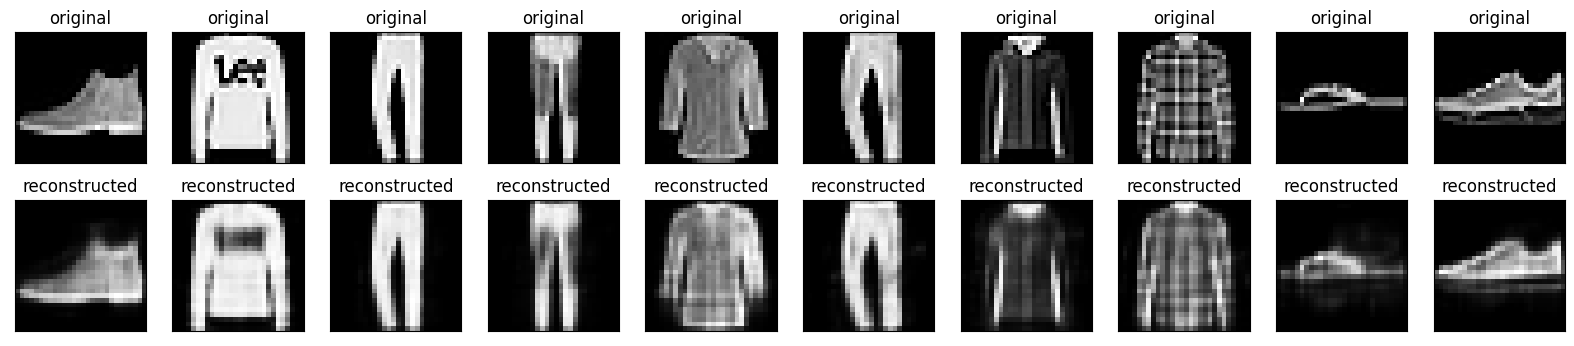

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Second example: Image denoising


![Image denoising results](images/image_denoise_fmnist_results.png)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [11]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


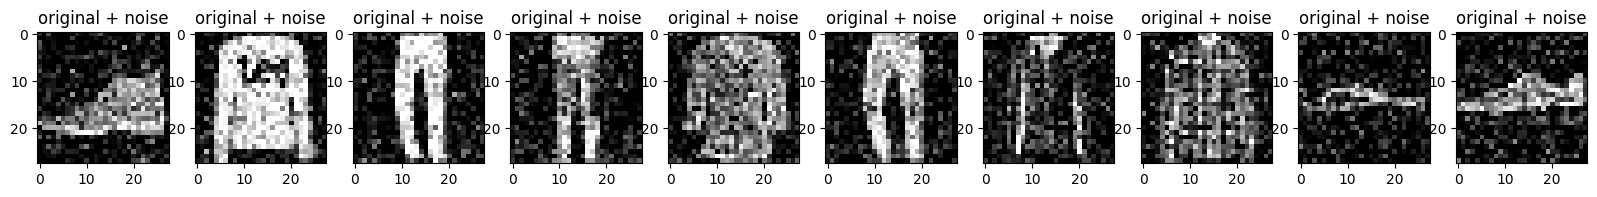

In [12]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [13]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [14]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [15]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10


   1/1875 [..............................] - ETA: 1:29:24 - loss: 0.1796

  13/1875 [..............................] - ETA: 7s - loss: 0.1711     

  26/1875 [..............................] - ETA: 7s - loss: 0.1661

  39/1875 [..............................] - ETA: 7s - loss: 0.1571

  53/1875 [..............................] - ETA: 7s - loss: 0.1403

  67/1875 [>.............................] - ETA: 7s - loss: 0.1199

  81/1875 [>.............................] - ETA: 6s - loss: 0.1049

  95/1875 [>.............................] - ETA: 6s - loss: 0.0934

 109/1875 [>.............................] - ETA: 6s - loss: 0.0847

 123/1875 [>.............................] - ETA: 6s - loss: 0.0777

 136/1875 [=>............................] - ETA: 6s - loss: 0.0723

 150/1875 [=>............................] - ETA: 6s - loss: 0.0674

 164/1875 [=>............................] - ETA: 6s - loss: 0.0634

 178/1875 [=>............................] - ETA: 6s - loss: 0.0599

 192/1875 [==>...........................] - ETA: 6s - loss: 0.0569

 206/1875 [==>...........................] - ETA: 6s - loss: 0.0543

 220/1875 [==>...........................] - ETA: 6s - loss: 0.0519

 234/1875 [==>...........................] - ETA: 6s - loss: 0.0498

 248/1875 [==>...........................] - ETA: 6s - loss: 0.0480

 262/1875 [===>..........................] - ETA: 6s - loss: 0.0463

 275/1875 [===>..........................] - ETA: 6s - loss: 0.0449

 288/1875 [===>..........................] - ETA: 6s - loss: 0.0436

 302/1875 [===>..........................] - ETA: 5s - loss: 0.0423

 316/1875 [====>.........................] - ETA: 5s - loss: 0.0411

 330/1875 [====>.........................] - ETA: 5s - loss: 0.0400

 344/1875 [====>.........................] - ETA: 5s - loss: 0.0390

 358/1875 [====>.........................] - ETA: 5s - loss: 0.0381

 372/1875 [====>.........................] - ETA: 5s - loss: 0.0372

 386/1875 [=====>........................] - ETA: 5s - loss: 0.0364

 400/1875 [=====>........................] - ETA: 5s - loss: 0.0356

 414/1875 [=====>........................] - ETA: 5s - loss: 0.0349

 428/1875 [=====>........................] - ETA: 5s - loss: 0.0342

 442/1875 [======>.......................] - ETA: 5s - loss: 0.0336

 456/1875 [======>.......................] - ETA: 5s - loss: 0.0330

 470/1875 [======>.......................] - ETA: 5s - loss: 0.0324

 484/1875 [======>.......................] - ETA: 5s - loss: 0.0319

 498/1875 [======>.......................] - ETA: 5s - loss: 0.0314

 512/1875 [=======>......................] - ETA: 5s - loss: 0.0309

 526/1875 [=======>......................] - ETA: 5s - loss: 0.0304

 540/1875 [=======>......................] - ETA: 5s - loss: 0.0299

 554/1875 [=======>......................] - ETA: 4s - loss: 0.0295

 567/1875 [========>.....................] - ETA: 4s - loss: 0.0292

 581/1875 [========>.....................] - ETA: 4s - loss: 0.0288

 595/1875 [========>.....................] - ETA: 4s - loss: 0.0284

 609/1875 [========>.....................] - ETA: 4s - loss: 0.0281

 623/1875 [========>.....................] - ETA: 4s - loss: 0.0277

 638/1875 [=========>....................] - ETA: 4s - loss: 0.0274

 652/1875 [=========>....................] - ETA: 4s - loss: 0.0271

 666/1875 [=========>....................] - ETA: 4s - loss: 0.0267

 680/1875 [=========>....................] - ETA: 4s - loss: 0.0265

 694/1875 [==========>...................] - ETA: 4s - loss: 0.0262

 708/1875 [==========>...................] - ETA: 4s - loss: 0.0259

 722/1875 [==========>...................] - ETA: 4s - loss: 0.0256

 736/1875 [==========>...................] - ETA: 4s - loss: 0.0254

 750/1875 [===========>..................] - ETA: 4s - loss: 0.0251

 764/1875 [===========>..................] - ETA: 4s - loss: 0.0249

 778/1875 [===========>..................] - ETA: 4s - loss: 0.0247

 792/1875 [===========>..................] - ETA: 4s - loss: 0.0245

 806/1875 [===========>..................] - ETA: 3s - loss: 0.0242

 820/1875 [============>.................] - ETA: 3s - loss: 0.0240

 835/1875 [============>.................] - ETA: 3s - loss: 0.0238

 849/1875 [============>.................] - ETA: 3s - loss: 0.0236

 863/1875 [============>.................] - ETA: 3s - loss: 0.0234

 877/1875 [=============>................] - ETA: 3s - loss: 0.0233

 891/1875 [=============>................] - ETA: 3s - loss: 0.0231

 905/1875 [=============>................] - ETA: 3s - loss: 0.0229

 920/1875 [=============>................] - ETA: 3s - loss: 0.0227

 935/1875 [=============>................] - ETA: 3s - loss: 0.0226

 949/1875 [==============>...............] - ETA: 3s - loss: 0.0224

 963/1875 [==============>...............] - ETA: 3s - loss: 0.0222

 977/1875 [==============>...............] - ETA: 3s - loss: 0.0221

 991/1875 [==============>...............] - ETA: 3s - loss: 0.0220

1005/1875 [===============>..............] - ETA: 3s - loss: 0.0218

1020/1875 [===============>..............] - ETA: 3s - loss: 0.0217

1034/1875 [===============>..............] - ETA: 3s - loss: 0.0215

1049/1875 [===============>..............] - ETA: 3s - loss: 0.0214

1063/1875 [================>.............] - ETA: 3s - loss: 0.0213

1077/1875 [================>.............] - ETA: 2s - loss: 0.0211

1091/1875 [================>.............] - ETA: 2s - loss: 0.0210

1105/1875 [================>.............] - ETA: 2s - loss: 0.0209

1119/1875 [================>.............] - ETA: 2s - loss: 0.0208

1133/1875 [=================>............] - ETA: 2s - loss: 0.0207

1147/1875 [=================>............] - ETA: 2s - loss: 0.0205

1161/1875 [=================>............] - ETA: 2s - loss: 0.0204

1175/1875 [=================>............] - ETA: 2s - loss: 0.0203

1189/1875 [==================>...........] - ETA: 2s - loss: 0.0202

1203/1875 [==================>...........] - ETA: 2s - loss: 0.0201

1218/1875 [==================>...........] - ETA: 2s - loss: 0.0200

1232/1875 [==================>...........] - ETA: 2s - loss: 0.0199

1247/1875 [==================>...........] - ETA: 2s - loss: 0.0198

1262/1875 [===================>..........] - ETA: 2s - loss: 0.0197

1276/1875 [===================>..........] - ETA: 2s - loss: 0.0196

1290/1875 [===================>..........] - ETA: 2s - loss: 0.0195

1304/1875 [===================>..........] - ETA: 2s - loss: 0.0194

1319/1875 [====================>.........] - ETA: 2s - loss: 0.0193

1333/1875 [====================>.........] - ETA: 1s - loss: 0.0192

1347/1875 [====================>.........] - ETA: 1s - loss: 0.0192

1361/1875 [====================>.........] - ETA: 1s - loss: 0.0191

1375/1875 [=====================>........] - ETA: 1s - loss: 0.0190

1390/1875 [=====================>........] - ETA: 1s - loss: 0.0189

1404/1875 [=====================>........] - ETA: 1s - loss: 0.0188

1418/1875 [=====================>........] - ETA: 1s - loss: 0.0187

1433/1875 [=====================>........] - ETA: 1s - loss: 0.0187

1447/1875 [======================>.......] - ETA: 1s - loss: 0.0186

1461/1875 [======================>.......] - ETA: 1s - loss: 0.0185

1476/1875 [======================>.......] - ETA: 1s - loss: 0.0184

1491/1875 [======================>.......] - ETA: 1s - loss: 0.0184

1505/1875 [=======================>......] - ETA: 1s - loss: 0.0183

1519/1875 [=======================>......] - ETA: 1s - loss: 0.0182

1533/1875 [=======================>......] - ETA: 1s - loss: 0.0181

1547/1875 [=======================>......] - ETA: 1s - loss: 0.0181

1561/1875 [=======================>......] - ETA: 1s - loss: 0.0180

1575/1875 [========================>.....] - ETA: 1s - loss: 0.0179

1589/1875 [========================>.....] - ETA: 1s - loss: 0.0179

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0178

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0177

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0177

1645/1875 [=========================>....] - ETA: 0s - loss: 0.0176

1659/1875 [=========================>....] - ETA: 0s - loss: 0.0176

1673/1875 [=========================>....] - ETA: 0s - loss: 0.0175

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0174

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0174

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0173

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0173

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0172

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0171

1771/1875 [===========================>..] - ETA: 0s - loss: 0.0171

1785/1875 [===========================>..] - ETA: 0s - loss: 0.0170

1799/1875 [===========================>..] - ETA: 0s - loss: 0.0170

1813/1875 [============================>.] - ETA: 0s - loss: 0.0169

1827/1875 [============================>.] - ETA: 0s - loss: 0.0169

1841/1875 [============================>.] - ETA: 0s - loss: 0.0168

1855/1875 [============================>.] - ETA: 0s - loss: 0.0168

1869/1875 [============================>.] - ETA: 0s - loss: 0.0167

1875/1875 [==============================] - 11s 4ms/step - loss: 0.0167 - val_loss: 0.0100


Epoch 2/10


   1/1875 [..............................] - ETA: 9s - loss: 0.0089

  15/1875 [..............................] - ETA: 6s - loss: 0.0098

  29/1875 [..............................] - ETA: 6s - loss: 0.0098

  43/1875 [..............................] - ETA: 6s - loss: 0.0099

  57/1875 [..............................] - ETA: 6s - loss: 0.0099

  71/1875 [>.............................] - ETA: 6s - loss: 0.0099

  85/1875 [>.............................] - ETA: 6s - loss: 0.0099

  99/1875 [>.............................] - ETA: 6s - loss: 0.0099

 113/1875 [>.............................] - ETA: 6s - loss: 0.0099

 127/1875 [=>............................] - ETA: 6s - loss: 0.0099

 141/1875 [=>............................] - ETA: 6s - loss: 0.0099

 155/1875 [=>............................] - ETA: 6s - loss: 0.0099

 169/1875 [=>............................] - ETA: 6s - loss: 0.0099

 183/1875 [=>............................] - ETA: 6s - loss: 0.0099

 197/1875 [==>...........................] - ETA: 6s - loss: 0.0098

 211/1875 [==>...........................] - ETA: 6s - loss: 0.0098

 225/1875 [==>...........................] - ETA: 6s - loss: 0.0098

 239/1875 [==>...........................] - ETA: 6s - loss: 0.0098

 253/1875 [===>..........................] - ETA: 5s - loss: 0.0098

 267/1875 [===>..........................] - ETA: 5s - loss: 0.0098

 281/1875 [===>..........................] - ETA: 5s - loss: 0.0097

 295/1875 [===>..........................] - ETA: 5s - loss: 0.0097

 309/1875 [===>..........................] - ETA: 5s - loss: 0.0097

 323/1875 [====>.........................] - ETA: 5s - loss: 0.0097

 337/1875 [====>.........................] - ETA: 5s - loss: 0.0097

 351/1875 [====>.........................] - ETA: 5s - loss: 0.0097

 365/1875 [====>.........................] - ETA: 5s - loss: 0.0097

 379/1875 [=====>........................] - ETA: 5s - loss: 0.0097

 393/1875 [=====>........................] - ETA: 5s - loss: 0.0097

 407/1875 [=====>........................] - ETA: 5s - loss: 0.0097

 421/1875 [=====>........................] - ETA: 5s - loss: 0.0097

 435/1875 [=====>........................] - ETA: 5s - loss: 0.0097

 450/1875 [======>.......................] - ETA: 5s - loss: 0.0097

 464/1875 [======>.......................] - ETA: 5s - loss: 0.0096

 478/1875 [======>.......................] - ETA: 5s - loss: 0.0096

 492/1875 [======>.......................] - ETA: 5s - loss: 0.0096

 506/1875 [=======>......................] - ETA: 5s - loss: 0.0096

 520/1875 [=======>......................] - ETA: 4s - loss: 0.0096

 534/1875 [=======>......................] - ETA: 4s - loss: 0.0096

 548/1875 [=======>......................] - ETA: 4s - loss: 0.0096

 562/1875 [=======>......................] - ETA: 4s - loss: 0.0096

 576/1875 [========>.....................] - ETA: 4s - loss: 0.0096

 590/1875 [========>.....................] - ETA: 4s - loss: 0.0096

 604/1875 [========>.....................] - ETA: 4s - loss: 0.0096

 618/1875 [========>.....................] - ETA: 4s - loss: 0.0096

 632/1875 [=========>....................] - ETA: 4s - loss: 0.0096

 646/1875 [=========>....................] - ETA: 4s - loss: 0.0095

 660/1875 [=========>....................] - ETA: 4s - loss: 0.0095

 673/1875 [=========>....................] - ETA: 4s - loss: 0.0095

 687/1875 [=========>....................] - ETA: 4s - loss: 0.0095

 701/1875 [==========>...................] - ETA: 4s - loss: 0.0095

 714/1875 [==========>...................] - ETA: 4s - loss: 0.0095

 728/1875 [==========>...................] - ETA: 4s - loss: 0.0095

 742/1875 [==========>...................] - ETA: 4s - loss: 0.0095

 756/1875 [===========>..................] - ETA: 4s - loss: 0.0095

 770/1875 [===========>..................] - ETA: 4s - loss: 0.0095

 784/1875 [===========>..................] - ETA: 4s - loss: 0.0094

 798/1875 [===========>..................] - ETA: 3s - loss: 0.0094

 812/1875 [===========>..................] - ETA: 3s - loss: 0.0094

 826/1875 [============>.................] - ETA: 3s - loss: 0.0094

 840/1875 [============>.................] - ETA: 3s - loss: 0.0094

 854/1875 [============>.................] - ETA: 3s - loss: 0.0094

 868/1875 [============>.................] - ETA: 3s - loss: 0.0094

 882/1875 [=============>................] - ETA: 3s - loss: 0.0094

 896/1875 [=============>................] - ETA: 3s - loss: 0.0094

 910/1875 [=============>................] - ETA: 3s - loss: 0.0094

 924/1875 [=============>................] - ETA: 3s - loss: 0.0094

 938/1875 [==============>...............] - ETA: 3s - loss: 0.0094

 952/1875 [==============>...............] - ETA: 3s - loss: 0.0093

 966/1875 [==============>...............] - ETA: 3s - loss: 0.0093

 980/1875 [==============>...............] - ETA: 3s - loss: 0.0093

 994/1875 [==============>...............] - ETA: 3s - loss: 0.0093

1008/1875 [===============>..............] - ETA: 3s - loss: 0.0093

1022/1875 [===============>..............] - ETA: 3s - loss: 0.0093

1036/1875 [===============>..............] - ETA: 3s - loss: 0.0093

1050/1875 [===============>..............] - ETA: 3s - loss: 0.0093

1064/1875 [================>.............] - ETA: 2s - loss: 0.0093

1078/1875 [================>.............] - ETA: 2s - loss: 0.0093

1092/1875 [================>.............] - ETA: 2s - loss: 0.0093

1106/1875 [================>.............] - ETA: 2s - loss: 0.0093

1120/1875 [================>.............] - ETA: 2s - loss: 0.0093

1134/1875 [=================>............] - ETA: 2s - loss: 0.0093

1148/1875 [=================>............] - ETA: 2s - loss: 0.0093

1162/1875 [=================>............] - ETA: 2s - loss: 0.0092

1176/1875 [=================>............] - ETA: 2s - loss: 0.0092

1190/1875 [==================>...........] - ETA: 2s - loss: 0.0092

1204/1875 [==================>...........] - ETA: 2s - loss: 0.0092

1218/1875 [==================>...........] - ETA: 2s - loss: 0.0092

1232/1875 [==================>...........] - ETA: 2s - loss: 0.0092

1246/1875 [==================>...........] - ETA: 2s - loss: 0.0092

1260/1875 [===================>..........] - ETA: 2s - loss: 0.0092

1274/1875 [===================>..........] - ETA: 2s - loss: 0.0092

1288/1875 [===================>..........] - ETA: 2s - loss: 0.0092

1302/1875 [===================>..........] - ETA: 2s - loss: 0.0092

1316/1875 [====================>.........] - ETA: 2s - loss: 0.0092

1330/1875 [====================>.........] - ETA: 2s - loss: 0.0092

1344/1875 [====================>.........] - ETA: 1s - loss: 0.0092

1358/1875 [====================>.........] - ETA: 1s - loss: 0.0092

1372/1875 [====================>.........] - ETA: 1s - loss: 0.0092

1386/1875 [=====================>........] - ETA: 1s - loss: 0.0092

1400/1875 [=====================>........] - ETA: 1s - loss: 0.0091

1414/1875 [=====================>........] - ETA: 1s - loss: 0.0091

1428/1875 [=====================>........] - ETA: 1s - loss: 0.0091

1442/1875 [======================>.......] - ETA: 1s - loss: 0.0091

1456/1875 [======================>.......] - ETA: 1s - loss: 0.0091

1470/1875 [======================>.......] - ETA: 1s - loss: 0.0091

1484/1875 [======================>.......] - ETA: 1s - loss: 0.0091

1498/1875 [======================>.......] - ETA: 1s - loss: 0.0091

1512/1875 [=======================>......] - ETA: 1s - loss: 0.0091

1526/1875 [=======================>......] - ETA: 1s - loss: 0.0091

1540/1875 [=======================>......] - ETA: 1s - loss: 0.0091

1554/1875 [=======================>......] - ETA: 1s - loss: 0.0091

1568/1875 [========================>.....] - ETA: 1s - loss: 0.0091

1582/1875 [========================>.....] - ETA: 1s - loss: 0.0091

1596/1875 [========================>.....] - ETA: 1s - loss: 0.0091

1610/1875 [========================>.....] - ETA: 0s - loss: 0.0091

1624/1875 [========================>.....] - ETA: 0s - loss: 0.0091

1638/1875 [=========================>....] - ETA: 0s - loss: 0.0091

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0090

1666/1875 [=========================>....] - ETA: 0s - loss: 0.0090

1680/1875 [=========================>....] - ETA: 0s - loss: 0.0090

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0090

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0090

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0090

1736/1875 [==========================>...] - ETA: 0s - loss: 0.0090

1750/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1792/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1806/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1820/1875 [============================>.] - ETA: 0s - loss: 0.0090

1834/1875 [============================>.] - ETA: 0s - loss: 0.0090

1848/1875 [============================>.] - ETA: 0s - loss: 0.0090

1862/1875 [============================>.] - ETA: 0s - loss: 0.0090

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0090 - val_loss: 0.0083


Epoch 3/10


   1/1875 [..............................] - ETA: 9s - loss: 0.0080

  15/1875 [..............................] - ETA: 6s - loss: 0.0081

  29/1875 [..............................] - ETA: 6s - loss: 0.0082

  43/1875 [..............................] - ETA: 6s - loss: 0.0082

  57/1875 [..............................] - ETA: 6s - loss: 0.0083

  71/1875 [>.............................] - ETA: 6s - loss: 0.0082

  85/1875 [>.............................] - ETA: 6s - loss: 0.0082

  99/1875 [>.............................] - ETA: 6s - loss: 0.0082

 113/1875 [>.............................] - ETA: 6s - loss: 0.0082

 127/1875 [=>............................] - ETA: 6s - loss: 0.0082

 141/1875 [=>............................] - ETA: 6s - loss: 0.0082

 155/1875 [=>............................] - ETA: 6s - loss: 0.0083

 169/1875 [=>............................] - ETA: 6s - loss: 0.0083

 182/1875 [=>............................] - ETA: 6s - loss: 0.0083

 196/1875 [==>...........................] - ETA: 6s - loss: 0.0083

 210/1875 [==>...........................] - ETA: 6s - loss: 0.0082

 224/1875 [==>...........................] - ETA: 6s - loss: 0.0082

 238/1875 [==>...........................] - ETA: 6s - loss: 0.0083

 252/1875 [===>..........................] - ETA: 6s - loss: 0.0082

 266/1875 [===>..........................] - ETA: 5s - loss: 0.0082

 280/1875 [===>..........................] - ETA: 5s - loss: 0.0082

 294/1875 [===>..........................] - ETA: 5s - loss: 0.0082

 308/1875 [===>..........................] - ETA: 5s - loss: 0.0082

 322/1875 [====>.........................] - ETA: 5s - loss: 0.0082

 336/1875 [====>.........................] - ETA: 5s - loss: 0.0082

 350/1875 [====>.........................] - ETA: 5s - loss: 0.0082

 364/1875 [====>.........................] - ETA: 5s - loss: 0.0082

 378/1875 [=====>........................] - ETA: 5s - loss: 0.0082

 392/1875 [=====>........................] - ETA: 5s - loss: 0.0082

 406/1875 [=====>........................] - ETA: 5s - loss: 0.0081

 420/1875 [=====>........................] - ETA: 5s - loss: 0.0081

 434/1875 [=====>........................] - ETA: 5s - loss: 0.0081

 448/1875 [======>.......................] - ETA: 5s - loss: 0.0081

 462/1875 [======>.......................] - ETA: 5s - loss: 0.0081

 476/1875 [======>.......................] - ETA: 5s - loss: 0.0081

 490/1875 [======>.......................] - ETA: 5s - loss: 0.0081

 504/1875 [=======>......................] - ETA: 5s - loss: 0.0081

 518/1875 [=======>......................] - ETA: 5s - loss: 0.0081

 532/1875 [=======>......................] - ETA: 4s - loss: 0.0081

 546/1875 [=======>......................] - ETA: 4s - loss: 0.0081

 560/1875 [=======>......................] - ETA: 4s - loss: 0.0081

 574/1875 [========>.....................] - ETA: 4s - loss: 0.0081

 588/1875 [========>.....................] - ETA: 4s - loss: 0.0081

 602/1875 [========>.....................] - ETA: 4s - loss: 0.0081

 616/1875 [========>.....................] - ETA: 4s - loss: 0.0081

 630/1875 [=========>....................] - ETA: 4s - loss: 0.0081

 644/1875 [=========>....................] - ETA: 4s - loss: 0.0081

 658/1875 [=========>....................] - ETA: 4s - loss: 0.0081

 672/1875 [=========>....................] - ETA: 4s - loss: 0.0081

 686/1875 [=========>....................] - ETA: 4s - loss: 0.0081

 700/1875 [==========>...................] - ETA: 4s - loss: 0.0081

 714/1875 [==========>...................] - ETA: 4s - loss: 0.0081

 728/1875 [==========>...................] - ETA: 4s - loss: 0.0081

 742/1875 [==========>...................] - ETA: 4s - loss: 0.0081

 756/1875 [===========>..................] - ETA: 4s - loss: 0.0081

 770/1875 [===========>..................] - ETA: 4s - loss: 0.0081

 785/1875 [===========>..................] - ETA: 4s - loss: 0.0081

 799/1875 [===========>..................] - ETA: 3s - loss: 0.0081

 813/1875 [============>.................] - ETA: 3s - loss: 0.0081

 827/1875 [============>.................] - ETA: 3s - loss: 0.0081

 841/1875 [============>.................] - ETA: 3s - loss: 0.0081

 855/1875 [============>.................] - ETA: 3s - loss: 0.0080

 868/1875 [============>.................] - ETA: 3s - loss: 0.0080

 882/1875 [=============>................] - ETA: 3s - loss: 0.0080

 896/1875 [=============>................] - ETA: 3s - loss: 0.0080

 910/1875 [=============>................] - ETA: 3s - loss: 0.0080

 924/1875 [=============>................] - ETA: 3s - loss: 0.0080

 938/1875 [==============>...............] - ETA: 3s - loss: 0.0080

 952/1875 [==============>...............] - ETA: 3s - loss: 0.0080

 966/1875 [==============>...............] - ETA: 3s - loss: 0.0080

 980/1875 [==============>...............] - ETA: 3s - loss: 0.0080

 994/1875 [==============>...............] - ETA: 3s - loss: 0.0080

1008/1875 [===============>..............] - ETA: 3s - loss: 0.0080

1022/1875 [===============>..............] - ETA: 3s - loss: 0.0080

1036/1875 [===============>..............] - ETA: 3s - loss: 0.0080

1050/1875 [===============>..............] - ETA: 3s - loss: 0.0080

1064/1875 [================>.............] - ETA: 3s - loss: 0.0080

1078/1875 [================>.............] - ETA: 2s - loss: 0.0080

1092/1875 [================>.............] - ETA: 2s - loss: 0.0080

1106/1875 [================>.............] - ETA: 2s - loss: 0.0080

1120/1875 [================>.............] - ETA: 2s - loss: 0.0080

1134/1875 [=================>............] - ETA: 2s - loss: 0.0080

1148/1875 [=================>............] - ETA: 2s - loss: 0.0080

1162/1875 [=================>............] - ETA: 2s - loss: 0.0080

1176/1875 [=================>............] - ETA: 2s - loss: 0.0080

1190/1875 [==================>...........] - ETA: 2s - loss: 0.0080

1204/1875 [==================>...........] - ETA: 2s - loss: 0.0080

1218/1875 [==================>...........] - ETA: 2s - loss: 0.0080

1232/1875 [==================>...........] - ETA: 2s - loss: 0.0080

1246/1875 [==================>...........] - ETA: 2s - loss: 0.0080

1260/1875 [===================>..........] - ETA: 2s - loss: 0.0080

1274/1875 [===================>..........] - ETA: 2s - loss: 0.0080

1288/1875 [===================>..........] - ETA: 2s - loss: 0.0080

1302/1875 [===================>..........] - ETA: 2s - loss: 0.0080

1316/1875 [====================>.........] - ETA: 2s - loss: 0.0080

1330/1875 [====================>.........] - ETA: 2s - loss: 0.0079

1344/1875 [====================>.........] - ETA: 1s - loss: 0.0079

1358/1875 [====================>.........] - ETA: 1s - loss: 0.0079

1372/1875 [====================>.........] - ETA: 1s - loss: 0.0079

1386/1875 [=====================>........] - ETA: 1s - loss: 0.0079

1400/1875 [=====================>........] - ETA: 1s - loss: 0.0079

1414/1875 [=====================>........] - ETA: 1s - loss: 0.0079

1428/1875 [=====================>........] - ETA: 1s - loss: 0.0079

1442/1875 [======================>.......] - ETA: 1s - loss: 0.0079

1456/1875 [======================>.......] - ETA: 1s - loss: 0.0079

1470/1875 [======================>.......] - ETA: 1s - loss: 0.0079

1484/1875 [======================>.......] - ETA: 1s - loss: 0.0079

1498/1875 [======================>.......] - ETA: 1s - loss: 0.0079

1512/1875 [=======================>......] - ETA: 1s - loss: 0.0079

1526/1875 [=======================>......] - ETA: 1s - loss: 0.0079

1540/1875 [=======================>......] - ETA: 1s - loss: 0.0079

1554/1875 [=======================>......] - ETA: 1s - loss: 0.0079

1568/1875 [========================>.....] - ETA: 1s - loss: 0.0079

1582/1875 [========================>.....] - ETA: 1s - loss: 0.0079

1596/1875 [========================>.....] - ETA: 1s - loss: 0.0079

1610/1875 [========================>.....] - ETA: 0s - loss: 0.0079

1624/1875 [========================>.....] - ETA: 0s - loss: 0.0079

1638/1875 [=========================>....] - ETA: 0s - loss: 0.0079

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0079

1666/1875 [=========================>....] - ETA: 0s - loss: 0.0079

1680/1875 [=========================>....] - ETA: 0s - loss: 0.0079

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0079

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0079

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0079

1737/1875 [==========================>...] - ETA: 0s - loss: 0.0079

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0079

1766/1875 [===========================>..] - ETA: 0s - loss: 0.0079

1780/1875 [===========================>..] - ETA: 0s - loss: 0.0079

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0079

1808/1875 [===========================>..] - ETA: 0s - loss: 0.0079

1822/1875 [============================>.] - ETA: 0s - loss: 0.0079

1836/1875 [============================>.] - ETA: 0s - loss: 0.0079

1850/1875 [============================>.] - ETA: 0s - loss: 0.0079

1864/1875 [============================>.] - ETA: 0s - loss: 0.0079

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0079 - val_loss: 0.0077


Epoch 4/10


   1/1875 [..............................] - ETA: 9s - loss: 0.0075

  15/1875 [..............................] - ETA: 6s - loss: 0.0079

  30/1875 [..............................] - ETA: 6s - loss: 0.0077

  44/1875 [..............................] - ETA: 6s - loss: 0.0076

  58/1875 [..............................] - ETA: 6s - loss: 0.0076

  72/1875 [>.............................] - ETA: 6s - loss: 0.0076

  86/1875 [>.............................] - ETA: 6s - loss: 0.0076

 100/1875 [>.............................] - ETA: 6s - loss: 0.0077

 114/1875 [>.............................] - ETA: 6s - loss: 0.0077

 128/1875 [=>............................] - ETA: 6s - loss: 0.0076

 142/1875 [=>............................] - ETA: 6s - loss: 0.0076

 156/1875 [=>............................] - ETA: 6s - loss: 0.0076

 170/1875 [=>............................] - ETA: 6s - loss: 0.0076

 184/1875 [=>............................] - ETA: 6s - loss: 0.0076

 198/1875 [==>...........................] - ETA: 6s - loss: 0.0076

 212/1875 [==>...........................] - ETA: 6s - loss: 0.0076

 226/1875 [==>...........................] - ETA: 6s - loss: 0.0076

 240/1875 [==>...........................] - ETA: 6s - loss: 0.0076

 254/1875 [===>..........................] - ETA: 5s - loss: 0.0076

 268/1875 [===>..........................] - ETA: 5s - loss: 0.0076

 282/1875 [===>..........................] - ETA: 5s - loss: 0.0076

 296/1875 [===>..........................] - ETA: 5s - loss: 0.0076

 310/1875 [===>..........................] - ETA: 5s - loss: 0.0076

 324/1875 [====>.........................] - ETA: 5s - loss: 0.0076

 338/1875 [====>.........................] - ETA: 5s - loss: 0.0076

 352/1875 [====>.........................] - ETA: 5s - loss: 0.0076

 366/1875 [====>.........................] - ETA: 5s - loss: 0.0076

 380/1875 [=====>........................] - ETA: 5s - loss: 0.0076

 394/1875 [=====>........................] - ETA: 5s - loss: 0.0076

 408/1875 [=====>........................] - ETA: 5s - loss: 0.0076

 422/1875 [=====>........................] - ETA: 5s - loss: 0.0076

 436/1875 [=====>........................] - ETA: 5s - loss: 0.0076

 450/1875 [======>.......................] - ETA: 5s - loss: 0.0076

 464/1875 [======>.......................] - ETA: 5s - loss: 0.0076

 478/1875 [======>.......................] - ETA: 5s - loss: 0.0076

 492/1875 [======>.......................] - ETA: 5s - loss: 0.0075

 506/1875 [=======>......................] - ETA: 5s - loss: 0.0075

 520/1875 [=======>......................] - ETA: 5s - loss: 0.0075

 534/1875 [=======>......................] - ETA: 4s - loss: 0.0075

 548/1875 [=======>......................] - ETA: 4s - loss: 0.0075

 562/1875 [=======>......................] - ETA: 4s - loss: 0.0075

 576/1875 [========>.....................] - ETA: 4s - loss: 0.0076

 590/1875 [========>.....................] - ETA: 4s - loss: 0.0075

 604/1875 [========>.....................] - ETA: 4s - loss: 0.0075

 618/1875 [========>.....................] - ETA: 4s - loss: 0.0075

 632/1875 [=========>....................] - ETA: 4s - loss: 0.0075

 646/1875 [=========>....................] - ETA: 4s - loss: 0.0075

 660/1875 [=========>....................] - ETA: 4s - loss: 0.0075

 674/1875 [=========>....................] - ETA: 4s - loss: 0.0075

 688/1875 [==========>...................] - ETA: 4s - loss: 0.0075

 702/1875 [==========>...................] - ETA: 4s - loss: 0.0075

 716/1875 [==========>...................] - ETA: 4s - loss: 0.0076

 730/1875 [==========>...................] - ETA: 4s - loss: 0.0076

 744/1875 [==========>...................] - ETA: 4s - loss: 0.0075

 758/1875 [===========>..................] - ETA: 4s - loss: 0.0075

 772/1875 [===========>..................] - ETA: 4s - loss: 0.0076

 786/1875 [===========>..................] - ETA: 4s - loss: 0.0076

 800/1875 [===========>..................] - ETA: 3s - loss: 0.0076

 814/1875 [============>.................] - ETA: 3s - loss: 0.0076

 828/1875 [============>.................] - ETA: 3s - loss: 0.0076

 842/1875 [============>.................] - ETA: 3s - loss: 0.0076

 856/1875 [============>.................] - ETA: 3s - loss: 0.0076

 870/1875 [============>.................] - ETA: 3s - loss: 0.0076

 884/1875 [=============>................] - ETA: 3s - loss: 0.0076

 898/1875 [=============>................] - ETA: 3s - loss: 0.0075

 912/1875 [=============>................] - ETA: 3s - loss: 0.0076

 926/1875 [=============>................] - ETA: 3s - loss: 0.0076

 940/1875 [==============>...............] - ETA: 3s - loss: 0.0076

 954/1875 [==============>...............] - ETA: 3s - loss: 0.0076

 968/1875 [==============>...............] - ETA: 3s - loss: 0.0076

 982/1875 [==============>...............] - ETA: 3s - loss: 0.0075

 996/1875 [==============>...............] - ETA: 3s - loss: 0.0075

1010/1875 [===============>..............] - ETA: 3s - loss: 0.0075

1024/1875 [===============>..............] - ETA: 3s - loss: 0.0075

1038/1875 [===============>..............] - ETA: 3s - loss: 0.0075

1052/1875 [===============>..............] - ETA: 3s - loss: 0.0075

1066/1875 [================>.............] - ETA: 2s - loss: 0.0075

1080/1875 [================>.............] - ETA: 2s - loss: 0.0075

1094/1875 [================>.............] - ETA: 2s - loss: 0.0075

1108/1875 [================>.............] - ETA: 2s - loss: 0.0075

1122/1875 [================>.............] - ETA: 2s - loss: 0.0075

1136/1875 [=================>............] - ETA: 2s - loss: 0.0075

1150/1875 [=================>............] - ETA: 2s - loss: 0.0075

1164/1875 [=================>............] - ETA: 2s - loss: 0.0075

1178/1875 [=================>............] - ETA: 2s - loss: 0.0075

1192/1875 [==================>...........] - ETA: 2s - loss: 0.0075

1206/1875 [==================>...........] - ETA: 2s - loss: 0.0075

1220/1875 [==================>...........] - ETA: 2s - loss: 0.0075

1234/1875 [==================>...........] - ETA: 2s - loss: 0.0075

1248/1875 [==================>...........] - ETA: 2s - loss: 0.0075

1262/1875 [===================>..........] - ETA: 2s - loss: 0.0075

1276/1875 [===================>..........] - ETA: 2s - loss: 0.0075

1290/1875 [===================>..........] - ETA: 2s - loss: 0.0075

1303/1875 [===================>..........] - ETA: 2s - loss: 0.0075

1317/1875 [====================>.........] - ETA: 2s - loss: 0.0075

1331/1875 [====================>.........] - ETA: 2s - loss: 0.0075

1345/1875 [====================>.........] - ETA: 1s - loss: 0.0075

1358/1875 [====================>.........] - ETA: 1s - loss: 0.0075

1371/1875 [====================>.........] - ETA: 1s - loss: 0.0075

1385/1875 [=====================>........] - ETA: 1s - loss: 0.0075

1399/1875 [=====================>........] - ETA: 1s - loss: 0.0075

1413/1875 [=====================>........] - ETA: 1s - loss: 0.0075

1427/1875 [=====================>........] - ETA: 1s - loss: 0.0075

1441/1875 [======================>.......] - ETA: 1s - loss: 0.0075

1455/1875 [======================>.......] - ETA: 1s - loss: 0.0075

1469/1875 [======================>.......] - ETA: 1s - loss: 0.0075

1483/1875 [======================>.......] - ETA: 1s - loss: 0.0075

1497/1875 [======================>.......] - ETA: 1s - loss: 0.0075

1511/1875 [=======================>......] - ETA: 1s - loss: 0.0075

1525/1875 [=======================>......] - ETA: 1s - loss: 0.0075

1539/1875 [=======================>......] - ETA: 1s - loss: 0.0075

1553/1875 [=======================>......] - ETA: 1s - loss: 0.0075

1567/1875 [========================>.....] - ETA: 1s - loss: 0.0075

1581/1875 [========================>.....] - ETA: 1s - loss: 0.0075

1595/1875 [========================>.....] - ETA: 1s - loss: 0.0075

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0075

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0075

1637/1875 [=========================>....] - ETA: 0s - loss: 0.0075

1651/1875 [=========================>....] - ETA: 0s - loss: 0.0075

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0075

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0075

1693/1875 [==========================>...] - ETA: 0s - loss: 0.0075

1707/1875 [==========================>...] - ETA: 0s - loss: 0.0075

1721/1875 [==========================>...] - ETA: 0s - loss: 0.0075

1735/1875 [==========================>...] - ETA: 0s - loss: 0.0075

1749/1875 [==========================>...] - ETA: 0s - loss: 0.0075

1763/1875 [===========================>..] - ETA: 0s - loss: 0.0075

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0075

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0075

1805/1875 [===========================>..] - ETA: 0s - loss: 0.0075

1819/1875 [============================>.] - ETA: 0s - loss: 0.0075

1833/1875 [============================>.] - ETA: 0s - loss: 0.0075

1847/1875 [============================>.] - ETA: 0s - loss: 0.0075

1861/1875 [============================>.] - ETA: 0s - loss: 0.0075

1875/1875 [==============================] - ETA: 0s - loss: 0.0075

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0075 - val_loss: 0.0074


Epoch 5/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0064

  15/1875 [..............................] - ETA: 6s - loss: 0.0072

  29/1875 [..............................] - ETA: 6s - loss: 0.0072

  43/1875 [..............................] - ETA: 6s - loss: 0.0073

  57/1875 [..............................] - ETA: 6s - loss: 0.0073

  71/1875 [>.............................] - ETA: 6s - loss: 0.0073

  85/1875 [>.............................] - ETA: 6s - loss: 0.0073

  99/1875 [>.............................] - ETA: 6s - loss: 0.0073

 113/1875 [>.............................] - ETA: 6s - loss: 0.0074

 127/1875 [=>............................] - ETA: 6s - loss: 0.0074

 141/1875 [=>............................] - ETA: 6s - loss: 0.0074

 154/1875 [=>............................] - ETA: 6s - loss: 0.0074

 168/1875 [=>............................] - ETA: 6s - loss: 0.0073

 182/1875 [=>............................] - ETA: 6s - loss: 0.0073

 196/1875 [==>...........................] - ETA: 6s - loss: 0.0073

 210/1875 [==>...........................] - ETA: 6s - loss: 0.0073

 224/1875 [==>...........................] - ETA: 6s - loss: 0.0073

 238/1875 [==>...........................] - ETA: 6s - loss: 0.0073

 252/1875 [===>..........................] - ETA: 5s - loss: 0.0073

 266/1875 [===>..........................] - ETA: 5s - loss: 0.0073

 279/1875 [===>..........................] - ETA: 5s - loss: 0.0073

 293/1875 [===>..........................] - ETA: 5s - loss: 0.0074

 307/1875 [===>..........................] - ETA: 5s - loss: 0.0074

 321/1875 [====>.........................] - ETA: 5s - loss: 0.0074

 335/1875 [====>.........................] - ETA: 5s - loss: 0.0073

 349/1875 [====>.........................] - ETA: 5s - loss: 0.0074

 363/1875 [====>.........................] - ETA: 5s - loss: 0.0074

 377/1875 [=====>........................] - ETA: 5s - loss: 0.0074

 391/1875 [=====>........................] - ETA: 5s - loss: 0.0074

 405/1875 [=====>........................] - ETA: 5s - loss: 0.0074

 419/1875 [=====>........................] - ETA: 5s - loss: 0.0074

 433/1875 [=====>........................] - ETA: 5s - loss: 0.0074

 447/1875 [======>.......................] - ETA: 5s - loss: 0.0074

 461/1875 [======>.......................] - ETA: 5s - loss: 0.0074

 475/1875 [======>.......................] - ETA: 5s - loss: 0.0074

 489/1875 [======>.......................] - ETA: 5s - loss: 0.0074

 503/1875 [=======>......................] - ETA: 5s - loss: 0.0074

 517/1875 [=======>......................] - ETA: 4s - loss: 0.0074

 531/1875 [=======>......................] - ETA: 4s - loss: 0.0074

 545/1875 [=======>......................] - ETA: 4s - loss: 0.0074

 559/1875 [=======>......................] - ETA: 4s - loss: 0.0074

 573/1875 [========>.....................] - ETA: 4s - loss: 0.0074

 587/1875 [========>.....................] - ETA: 4s - loss: 0.0074

 601/1875 [========>.....................] - ETA: 4s - loss: 0.0074

 615/1875 [========>.....................] - ETA: 4s - loss: 0.0074

 629/1875 [=========>....................] - ETA: 4s - loss: 0.0074

 643/1875 [=========>....................] - ETA: 4s - loss: 0.0074

 657/1875 [=========>....................] - ETA: 4s - loss: 0.0074

 671/1875 [=========>....................] - ETA: 4s - loss: 0.0074

 685/1875 [=========>....................] - ETA: 4s - loss: 0.0074

 699/1875 [==========>...................] - ETA: 4s - loss: 0.0074

 713/1875 [==========>...................] - ETA: 4s - loss: 0.0074

 727/1875 [==========>...................] - ETA: 4s - loss: 0.0074

 741/1875 [==========>...................] - ETA: 4s - loss: 0.0074

 755/1875 [===========>..................] - ETA: 4s - loss: 0.0074

 769/1875 [===========>..................] - ETA: 4s - loss: 0.0074

 783/1875 [===========>..................] - ETA: 4s - loss: 0.0074

 797/1875 [===========>..................] - ETA: 3s - loss: 0.0074

 811/1875 [===========>..................] - ETA: 3s - loss: 0.0074

 825/1875 [============>.................] - ETA: 3s - loss: 0.0074

 839/1875 [============>.................] - ETA: 3s - loss: 0.0074

 853/1875 [============>.................] - ETA: 3s - loss: 0.0074

 867/1875 [============>.................] - ETA: 3s - loss: 0.0074

 881/1875 [=============>................] - ETA: 3s - loss: 0.0074

 896/1875 [=============>................] - ETA: 3s - loss: 0.0074

 910/1875 [=============>................] - ETA: 3s - loss: 0.0074

 924/1875 [=============>................] - ETA: 3s - loss: 0.0074

 938/1875 [==============>...............] - ETA: 3s - loss: 0.0073

 952/1875 [==============>...............] - ETA: 3s - loss: 0.0073

 967/1875 [==============>...............] - ETA: 3s - loss: 0.0073

 982/1875 [==============>...............] - ETA: 3s - loss: 0.0073

 996/1875 [==============>...............] - ETA: 3s - loss: 0.0073

1010/1875 [===============>..............] - ETA: 3s - loss: 0.0073

1024/1875 [===============>..............] - ETA: 3s - loss: 0.0073

1038/1875 [===============>..............] - ETA: 3s - loss: 0.0073

1052/1875 [===============>..............] - ETA: 3s - loss: 0.0073

1066/1875 [================>.............] - ETA: 2s - loss: 0.0073

1080/1875 [================>.............] - ETA: 2s - loss: 0.0073

1094/1875 [================>.............] - ETA: 2s - loss: 0.0073

1108/1875 [================>.............] - ETA: 2s - loss: 0.0073

1122/1875 [================>.............] - ETA: 2s - loss: 0.0073

1136/1875 [=================>............] - ETA: 2s - loss: 0.0073

1150/1875 [=================>............] - ETA: 2s - loss: 0.0073

1164/1875 [=================>............] - ETA: 2s - loss: 0.0073

1178/1875 [=================>............] - ETA: 2s - loss: 0.0073

1192/1875 [==================>...........] - ETA: 2s - loss: 0.0073

1206/1875 [==================>...........] - ETA: 2s - loss: 0.0073

1220/1875 [==================>...........] - ETA: 2s - loss: 0.0073

1234/1875 [==================>...........] - ETA: 2s - loss: 0.0073

1248/1875 [==================>...........] - ETA: 2s - loss: 0.0073

1262/1875 [===================>..........] - ETA: 2s - loss: 0.0073

1276/1875 [===================>..........] - ETA: 2s - loss: 0.0073

1290/1875 [===================>..........] - ETA: 2s - loss: 0.0073

1305/1875 [===================>..........] - ETA: 2s - loss: 0.0073

1319/1875 [====================>.........] - ETA: 2s - loss: 0.0073

1333/1875 [====================>.........] - ETA: 1s - loss: 0.0073

1348/1875 [====================>.........] - ETA: 1s - loss: 0.0073

1362/1875 [====================>.........] - ETA: 1s - loss: 0.0073

1376/1875 [=====================>........] - ETA: 1s - loss: 0.0073

1390/1875 [=====================>........] - ETA: 1s - loss: 0.0073

1404/1875 [=====================>........] - ETA: 1s - loss: 0.0073

1418/1875 [=====================>........] - ETA: 1s - loss: 0.0073

1432/1875 [=====================>........] - ETA: 1s - loss: 0.0073

1446/1875 [======================>.......] - ETA: 1s - loss: 0.0073

1460/1875 [======================>.......] - ETA: 1s - loss: 0.0073

1474/1875 [======================>.......] - ETA: 1s - loss: 0.0073

1488/1875 [======================>.......] - ETA: 1s - loss: 0.0073

1502/1875 [=======================>......] - ETA: 1s - loss: 0.0073

1516/1875 [=======================>......] - ETA: 1s - loss: 0.0073

1530/1875 [=======================>......] - ETA: 1s - loss: 0.0073

1544/1875 [=======================>......] - ETA: 1s - loss: 0.0073

1559/1875 [=======================>......] - ETA: 1s - loss: 0.0073

1574/1875 [========================>.....] - ETA: 1s - loss: 0.0073

1589/1875 [========================>.....] - ETA: 1s - loss: 0.0073

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0073

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0073

1632/1875 [=========================>....] - ETA: 0s - loss: 0.0073

1646/1875 [=========================>....] - ETA: 0s - loss: 0.0073

1660/1875 [=========================>....] - ETA: 0s - loss: 0.0073

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0073

1688/1875 [==========================>...] - ETA: 0s - loss: 0.0073

1702/1875 [==========================>...] - ETA: 0s - loss: 0.0073

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0073

1732/1875 [==========================>...] - ETA: 0s - loss: 0.0073

1746/1875 [==========================>...] - ETA: 0s - loss: 0.0073

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0073

1774/1875 [===========================>..] - ETA: 0s - loss: 0.0073

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0073

1802/1875 [===========================>..] - ETA: 0s - loss: 0.0073

1816/1875 [============================>.] - ETA: 0s - loss: 0.0073

1830/1875 [============================>.] - ETA: 0s - loss: 0.0073

1844/1875 [============================>.] - ETA: 0s - loss: 0.0073

1858/1875 [============================>.] - ETA: 0s - loss: 0.0073

1872/1875 [============================>.] - ETA: 0s - loss: 0.0073

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0073 - val_loss: 0.0072


Epoch 6/10


   1/1875 [..............................] - ETA: 9s - loss: 0.0074

  15/1875 [..............................] - ETA: 6s - loss: 0.0070

  29/1875 [..............................] - ETA: 6s - loss: 0.0070

  43/1875 [..............................] - ETA: 6s - loss: 0.0071

  57/1875 [..............................] - ETA: 6s - loss: 0.0071

  71/1875 [>.............................] - ETA: 6s - loss: 0.0071

  85/1875 [>.............................] - ETA: 6s - loss: 0.0071

  99/1875 [>.............................] - ETA: 6s - loss: 0.0071

 113/1875 [>.............................] - ETA: 6s - loss: 0.0071

 127/1875 [=>............................] - ETA: 6s - loss: 0.0071

 141/1875 [=>............................] - ETA: 6s - loss: 0.0071

 155/1875 [=>............................] - ETA: 6s - loss: 0.0072

 169/1875 [=>............................] - ETA: 6s - loss: 0.0071

 183/1875 [=>............................] - ETA: 6s - loss: 0.0071

 197/1875 [==>...........................] - ETA: 6s - loss: 0.0071

 211/1875 [==>...........................] - ETA: 6s - loss: 0.0071

 225/1875 [==>...........................] - ETA: 6s - loss: 0.0071

 239/1875 [==>...........................] - ETA: 6s - loss: 0.0071

 253/1875 [===>..........................] - ETA: 6s - loss: 0.0071

 267/1875 [===>..........................] - ETA: 5s - loss: 0.0071

 281/1875 [===>..........................] - ETA: 5s - loss: 0.0072

 295/1875 [===>..........................] - ETA: 5s - loss: 0.0072

 309/1875 [===>..........................] - ETA: 5s - loss: 0.0072

 323/1875 [====>.........................] - ETA: 5s - loss: 0.0072

 337/1875 [====>.........................] - ETA: 5s - loss: 0.0071

 351/1875 [====>.........................] - ETA: 5s - loss: 0.0071

 365/1875 [====>.........................] - ETA: 5s - loss: 0.0072

 379/1875 [=====>........................] - ETA: 5s - loss: 0.0072

 393/1875 [=====>........................] - ETA: 5s - loss: 0.0072

 407/1875 [=====>........................] - ETA: 5s - loss: 0.0072

 420/1875 [=====>........................] - ETA: 5s - loss: 0.0072

 434/1875 [=====>........................] - ETA: 5s - loss: 0.0072

 448/1875 [======>.......................] - ETA: 5s - loss: 0.0072

 462/1875 [======>.......................] - ETA: 5s - loss: 0.0072

 475/1875 [======>.......................] - ETA: 5s - loss: 0.0071

 489/1875 [======>.......................] - ETA: 5s - loss: 0.0071

 503/1875 [=======>......................] - ETA: 5s - loss: 0.0071

 516/1875 [=======>......................] - ETA: 5s - loss: 0.0071

 529/1875 [=======>......................] - ETA: 5s - loss: 0.0071

 543/1875 [=======>......................] - ETA: 4s - loss: 0.0071

 557/1875 [=======>......................] - ETA: 4s - loss: 0.0071

 571/1875 [========>.....................] - ETA: 4s - loss: 0.0072

 585/1875 [========>.....................] - ETA: 4s - loss: 0.0072

 599/1875 [========>.....................] - ETA: 4s - loss: 0.0071

 613/1875 [========>.....................] - ETA: 4s - loss: 0.0072

 627/1875 [=========>....................] - ETA: 4s - loss: 0.0072

 641/1875 [=========>....................] - ETA: 4s - loss: 0.0072

 655/1875 [=========>....................] - ETA: 4s - loss: 0.0072

 669/1875 [=========>....................] - ETA: 4s - loss: 0.0072

 683/1875 [=========>....................] - ETA: 4s - loss: 0.0072

 698/1875 [==========>...................] - ETA: 4s - loss: 0.0072

 712/1875 [==========>...................] - ETA: 4s - loss: 0.0072

 727/1875 [==========>...................] - ETA: 4s - loss: 0.0071

 741/1875 [==========>...................] - ETA: 4s - loss: 0.0071

 755/1875 [===========>..................] - ETA: 4s - loss: 0.0072

 770/1875 [===========>..................] - ETA: 4s - loss: 0.0072

 785/1875 [===========>..................] - ETA: 4s - loss: 0.0072

 800/1875 [===========>..................] - ETA: 3s - loss: 0.0072

 814/1875 [============>.................] - ETA: 3s - loss: 0.0072

 828/1875 [============>.................] - ETA: 3s - loss: 0.0072

 842/1875 [============>.................] - ETA: 3s - loss: 0.0072

 857/1875 [============>.................] - ETA: 3s - loss: 0.0072

 871/1875 [============>.................] - ETA: 3s - loss: 0.0072

 885/1875 [=============>................] - ETA: 3s - loss: 0.0072

 899/1875 [=============>................] - ETA: 3s - loss: 0.0072

 913/1875 [=============>................] - ETA: 3s - loss: 0.0072

 927/1875 [=============>................] - ETA: 3s - loss: 0.0072

 941/1875 [==============>...............] - ETA: 3s - loss: 0.0072

 955/1875 [==============>...............] - ETA: 3s - loss: 0.0072

 970/1875 [==============>...............] - ETA: 3s - loss: 0.0072

 984/1875 [==============>...............] - ETA: 3s - loss: 0.0072

 998/1875 [==============>...............] - ETA: 3s - loss: 0.0072

1012/1875 [===============>..............] - ETA: 3s - loss: 0.0072

1026/1875 [===============>..............] - ETA: 3s - loss: 0.0072

1040/1875 [===============>..............] - ETA: 3s - loss: 0.0072

1054/1875 [===============>..............] - ETA: 3s - loss: 0.0072

1068/1875 [================>.............] - ETA: 2s - loss: 0.0071

1082/1875 [================>.............] - ETA: 2s - loss: 0.0071

1096/1875 [================>.............] - ETA: 2s - loss: 0.0071

1110/1875 [================>.............] - ETA: 2s - loss: 0.0071

1124/1875 [================>.............] - ETA: 2s - loss: 0.0071

1138/1875 [=================>............] - ETA: 2s - loss: 0.0071

1152/1875 [=================>............] - ETA: 2s - loss: 0.0071

1166/1875 [=================>............] - ETA: 2s - loss: 0.0071

1180/1875 [=================>............] - ETA: 2s - loss: 0.0071

1194/1875 [==================>...........] - ETA: 2s - loss: 0.0071

1208/1875 [==================>...........] - ETA: 2s - loss: 0.0071

1222/1875 [==================>...........] - ETA: 2s - loss: 0.0071

1237/1875 [==================>...........] - ETA: 2s - loss: 0.0071

1251/1875 [===================>..........] - ETA: 2s - loss: 0.0071

1266/1875 [===================>..........] - ETA: 2s - loss: 0.0071

1281/1875 [===================>..........] - ETA: 2s - loss: 0.0071

1296/1875 [===================>..........] - ETA: 2s - loss: 0.0071

1311/1875 [===================>..........] - ETA: 2s - loss: 0.0071

1326/1875 [====================>.........] - ETA: 2s - loss: 0.0071

1341/1875 [====================>.........] - ETA: 1s - loss: 0.0071

1356/1875 [====================>.........] - ETA: 1s - loss: 0.0071

1370/1875 [====================>.........] - ETA: 1s - loss: 0.0071

1385/1875 [=====================>........] - ETA: 1s - loss: 0.0071

1400/1875 [=====================>........] - ETA: 1s - loss: 0.0071

1415/1875 [=====================>........] - ETA: 1s - loss: 0.0071

1429/1875 [=====================>........] - ETA: 1s - loss: 0.0071

1443/1875 [======================>.......] - ETA: 1s - loss: 0.0071

1457/1875 [======================>.......] - ETA: 1s - loss: 0.0071

1471/1875 [======================>.......] - ETA: 1s - loss: 0.0071

1485/1875 [======================>.......] - ETA: 1s - loss: 0.0071

1499/1875 [======================>.......] - ETA: 1s - loss: 0.0071

1513/1875 [=======================>......] - ETA: 1s - loss: 0.0071

1527/1875 [=======================>......] - ETA: 1s - loss: 0.0071

1541/1875 [=======================>......] - ETA: 1s - loss: 0.0071

1555/1875 [=======================>......] - ETA: 1s - loss: 0.0071

1569/1875 [========================>.....] - ETA: 1s - loss: 0.0071

1583/1875 [========================>.....] - ETA: 1s - loss: 0.0071

1597/1875 [========================>.....] - ETA: 1s - loss: 0.0071

1611/1875 [========================>.....] - ETA: 0s - loss: 0.0071

1625/1875 [=========================>....] - ETA: 0s - loss: 0.0071

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0071

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0071

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0071

1681/1875 [=========================>....] - ETA: 0s - loss: 0.0071

1695/1875 [==========================>...] - ETA: 0s - loss: 0.0071

1709/1875 [==========================>...] - ETA: 0s - loss: 0.0071

1723/1875 [==========================>...] - ETA: 0s - loss: 0.0071

1737/1875 [==========================>...] - ETA: 0s - loss: 0.0071

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0071

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0071

1779/1875 [===========================>..] - ETA: 0s - loss: 0.0071

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0071

1808/1875 [===========================>..] - ETA: 0s - loss: 0.0071

1822/1875 [============================>.] - ETA: 0s - loss: 0.0071

1836/1875 [============================>.] - ETA: 0s - loss: 0.0071

1850/1875 [============================>.] - ETA: 0s - loss: 0.0071

1864/1875 [============================>.] - ETA: 0s - loss: 0.0071

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0071 - val_loss: 0.0071


Epoch 7/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0069

  15/1875 [..............................] - ETA: 6s - loss: 0.0069

  29/1875 [..............................] - ETA: 6s - loss: 0.0070

  43/1875 [..............................] - ETA: 6s - loss: 0.0071

  57/1875 [..............................] - ETA: 6s - loss: 0.0071

  71/1875 [>.............................] - ETA: 6s - loss: 0.0071

  85/1875 [>.............................] - ETA: 6s - loss: 0.0071

  99/1875 [>.............................] - ETA: 6s - loss: 0.0071

 113/1875 [>.............................] - ETA: 6s - loss: 0.0071

 127/1875 [=>............................] - ETA: 6s - loss: 0.0071

 141/1875 [=>............................] - ETA: 6s - loss: 0.0071

 156/1875 [=>............................] - ETA: 6s - loss: 0.0071

 170/1875 [=>............................] - ETA: 6s - loss: 0.0071

 184/1875 [=>............................] - ETA: 6s - loss: 0.0071

 198/1875 [==>...........................] - ETA: 6s - loss: 0.0071

 212/1875 [==>...........................] - ETA: 6s - loss: 0.0071

 226/1875 [==>...........................] - ETA: 5s - loss: 0.0071

 240/1875 [==>...........................] - ETA: 5s - loss: 0.0071

 254/1875 [===>..........................] - ETA: 5s - loss: 0.0071

 268/1875 [===>..........................] - ETA: 5s - loss: 0.0071

 282/1875 [===>..........................] - ETA: 5s - loss: 0.0071

 296/1875 [===>..........................] - ETA: 5s - loss: 0.0071

 310/1875 [===>..........................] - ETA: 5s - loss: 0.0071

 324/1875 [====>.........................] - ETA: 5s - loss: 0.0071

 338/1875 [====>.........................] - ETA: 5s - loss: 0.0071

 352/1875 [====>.........................] - ETA: 5s - loss: 0.0071

 366/1875 [====>.........................] - ETA: 5s - loss: 0.0071

 380/1875 [=====>........................] - ETA: 5s - loss: 0.0071

 394/1875 [=====>........................] - ETA: 5s - loss: 0.0071

 408/1875 [=====>........................] - ETA: 5s - loss: 0.0071

 422/1875 [=====>........................] - ETA: 5s - loss: 0.0071

 436/1875 [=====>........................] - ETA: 5s - loss: 0.0071

 450/1875 [======>.......................] - ETA: 5s - loss: 0.0071

 464/1875 [======>.......................] - ETA: 5s - loss: 0.0071

 478/1875 [======>.......................] - ETA: 5s - loss: 0.0071

 492/1875 [======>.......................] - ETA: 5s - loss: 0.0071

 506/1875 [=======>......................] - ETA: 4s - loss: 0.0071

 520/1875 [=======>......................] - ETA: 4s - loss: 0.0071

 534/1875 [=======>......................] - ETA: 4s - loss: 0.0071

 549/1875 [=======>......................] - ETA: 4s - loss: 0.0071

 563/1875 [========>.....................] - ETA: 4s - loss: 0.0071

 577/1875 [========>.....................] - ETA: 4s - loss: 0.0071

 591/1875 [========>.....................] - ETA: 4s - loss: 0.0071

 605/1875 [========>.....................] - ETA: 4s - loss: 0.0071

 619/1875 [========>.....................] - ETA: 4s - loss: 0.0071

 633/1875 [=========>....................] - ETA: 4s - loss: 0.0071

 647/1875 [=========>....................] - ETA: 4s - loss: 0.0071

 661/1875 [=========>....................] - ETA: 4s - loss: 0.0071

 675/1875 [=========>....................] - ETA: 4s - loss: 0.0071

 689/1875 [==========>...................] - ETA: 4s - loss: 0.0071

 703/1875 [==========>...................] - ETA: 4s - loss: 0.0071

 717/1875 [==========>...................] - ETA: 4s - loss: 0.0071

 731/1875 [==========>...................] - ETA: 4s - loss: 0.0071

 745/1875 [==========>...................] - ETA: 4s - loss: 0.0071

 759/1875 [===========>..................] - ETA: 4s - loss: 0.0071

 773/1875 [===========>..................] - ETA: 4s - loss: 0.0071

 787/1875 [===========>..................] - ETA: 3s - loss: 0.0071

 801/1875 [===========>..................] - ETA: 3s - loss: 0.0071

 815/1875 [============>.................] - ETA: 3s - loss: 0.0071

 829/1875 [============>.................] - ETA: 3s - loss: 0.0071

 843/1875 [============>.................] - ETA: 3s - loss: 0.0071

 857/1875 [============>.................] - ETA: 3s - loss: 0.0071

 871/1875 [============>.................] - ETA: 3s - loss: 0.0071

 885/1875 [=============>................] - ETA: 3s - loss: 0.0071

 899/1875 [=============>................] - ETA: 3s - loss: 0.0071

 913/1875 [=============>................] - ETA: 3s - loss: 0.0071

 927/1875 [=============>................] - ETA: 3s - loss: 0.0071

 941/1875 [==============>...............] - ETA: 3s - loss: 0.0071

 955/1875 [==============>...............] - ETA: 3s - loss: 0.0070

 969/1875 [==============>...............] - ETA: 3s - loss: 0.0071

 983/1875 [==============>...............] - ETA: 3s - loss: 0.0070

 997/1875 [==============>...............] - ETA: 3s - loss: 0.0070

1011/1875 [===============>..............] - ETA: 3s - loss: 0.0070

1025/1875 [===============>..............] - ETA: 3s - loss: 0.0070

1039/1875 [===============>..............] - ETA: 3s - loss: 0.0070

1053/1875 [===============>..............] - ETA: 3s - loss: 0.0070

1067/1875 [================>.............] - ETA: 2s - loss: 0.0070

1081/1875 [================>.............] - ETA: 2s - loss: 0.0070

1095/1875 [================>.............] - ETA: 2s - loss: 0.0070

1109/1875 [================>.............] - ETA: 2s - loss: 0.0070

1123/1875 [================>.............] - ETA: 2s - loss: 0.0070

1137/1875 [=================>............] - ETA: 2s - loss: 0.0070

1151/1875 [=================>............] - ETA: 2s - loss: 0.0070

1165/1875 [=================>............] - ETA: 2s - loss: 0.0070

1179/1875 [=================>............] - ETA: 2s - loss: 0.0070

1193/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1207/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1221/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1235/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1249/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1264/1875 [===================>..........] - ETA: 2s - loss: 0.0070

1278/1875 [===================>..........] - ETA: 2s - loss: 0.0070

1292/1875 [===================>..........] - ETA: 2s - loss: 0.0070

1306/1875 [===================>..........] - ETA: 2s - loss: 0.0070

1320/1875 [====================>.........] - ETA: 2s - loss: 0.0070

1334/1875 [====================>.........] - ETA: 1s - loss: 0.0070

1348/1875 [====================>.........] - ETA: 1s - loss: 0.0070

1362/1875 [====================>.........] - ETA: 1s - loss: 0.0070

1376/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1390/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1404/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1418/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1432/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1446/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1460/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1474/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1489/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1503/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1517/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1531/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1545/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1559/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1573/1875 [========================>.....] - ETA: 1s - loss: 0.0070

1587/1875 [========================>.....] - ETA: 1s - loss: 0.0070

1601/1875 [========================>.....] - ETA: 1s - loss: 0.0070

1615/1875 [========================>.....] - ETA: 0s - loss: 0.0070

1630/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1644/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1658/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1672/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1714/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1728/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1798/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1826/1875 [============================>.] - ETA: 0s - loss: 0.0070

1840/1875 [============================>.] - ETA: 0s - loss: 0.0070

1854/1875 [============================>.] - ETA: 0s - loss: 0.0070

1868/1875 [============================>.] - ETA: 0s - loss: 0.0070

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0070 - val_loss: 0.0070


Epoch 8/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0073

  15/1875 [..............................] - ETA: 6s - loss: 0.0071

  29/1875 [..............................] - ETA: 6s - loss: 0.0071

  43/1875 [..............................] - ETA: 6s - loss: 0.0070

  57/1875 [..............................] - ETA: 6s - loss: 0.0070

  71/1875 [>.............................] - ETA: 6s - loss: 0.0070

  85/1875 [>.............................] - ETA: 6s - loss: 0.0070

  99/1875 [>.............................] - ETA: 6s - loss: 0.0070

 113/1875 [>.............................] - ETA: 6s - loss: 0.0070

 127/1875 [=>............................] - ETA: 6s - loss: 0.0070

 141/1875 [=>............................] - ETA: 6s - loss: 0.0070

 156/1875 [=>............................] - ETA: 6s - loss: 0.0070

 171/1875 [=>............................] - ETA: 6s - loss: 0.0070

 186/1875 [=>............................] - ETA: 6s - loss: 0.0070

 201/1875 [==>...........................] - ETA: 6s - loss: 0.0070

 215/1875 [==>...........................] - ETA: 5s - loss: 0.0070

 229/1875 [==>...........................] - ETA: 5s - loss: 0.0070

 243/1875 [==>...........................] - ETA: 5s - loss: 0.0070

 257/1875 [===>..........................] - ETA: 5s - loss: 0.0070

 272/1875 [===>..........................] - ETA: 5s - loss: 0.0070

 286/1875 [===>..........................] - ETA: 5s - loss: 0.0070

 301/1875 [===>..........................] - ETA: 5s - loss: 0.0070

 315/1875 [====>.........................] - ETA: 5s - loss: 0.0070

 329/1875 [====>.........................] - ETA: 5s - loss: 0.0069

 343/1875 [====>.........................] - ETA: 5s - loss: 0.0070

 357/1875 [====>.........................] - ETA: 5s - loss: 0.0070

 371/1875 [====>.........................] - ETA: 5s - loss: 0.0070

 385/1875 [=====>........................] - ETA: 5s - loss: 0.0070

 399/1875 [=====>........................] - ETA: 5s - loss: 0.0070

 413/1875 [=====>........................] - ETA: 5s - loss: 0.0069

 427/1875 [=====>........................] - ETA: 5s - loss: 0.0069

 441/1875 [======>.......................] - ETA: 5s - loss: 0.0069

 455/1875 [======>.......................] - ETA: 5s - loss: 0.0069

 469/1875 [======>.......................] - ETA: 5s - loss: 0.0069

 483/1875 [======>.......................] - ETA: 5s - loss: 0.0069

 497/1875 [======>.......................] - ETA: 4s - loss: 0.0069

 511/1875 [=======>......................] - ETA: 4s - loss: 0.0069

 525/1875 [=======>......................] - ETA: 4s - loss: 0.0069

 539/1875 [=======>......................] - ETA: 4s - loss: 0.0069

 553/1875 [=======>......................] - ETA: 4s - loss: 0.0069

 567/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 581/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 595/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 609/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 623/1875 [========>.....................] - ETA: 4s - loss: 0.0070

 637/1875 [=========>....................] - ETA: 4s - loss: 0.0070

 651/1875 [=========>....................] - ETA: 4s - loss: 0.0070

 665/1875 [=========>....................] - ETA: 4s - loss: 0.0070

 679/1875 [=========>....................] - ETA: 4s - loss: 0.0069

 693/1875 [==========>...................] - ETA: 4s - loss: 0.0070

 707/1875 [==========>...................] - ETA: 4s - loss: 0.0070

 721/1875 [==========>...................] - ETA: 4s - loss: 0.0070

 735/1875 [==========>...................] - ETA: 4s - loss: 0.0069

 749/1875 [==========>...................] - ETA: 4s - loss: 0.0069

 763/1875 [===========>..................] - ETA: 4s - loss: 0.0069

 777/1875 [===========>..................] - ETA: 3s - loss: 0.0069

 791/1875 [===========>..................] - ETA: 3s - loss: 0.0069

 805/1875 [===========>..................] - ETA: 3s - loss: 0.0069

 819/1875 [============>.................] - ETA: 3s - loss: 0.0069

 833/1875 [============>.................] - ETA: 3s - loss: 0.0069

 847/1875 [============>.................] - ETA: 3s - loss: 0.0069

 861/1875 [============>.................] - ETA: 3s - loss: 0.0069

 875/1875 [=============>................] - ETA: 3s - loss: 0.0069

 889/1875 [=============>................] - ETA: 3s - loss: 0.0069

 903/1875 [=============>................] - ETA: 3s - loss: 0.0069

 917/1875 [=============>................] - ETA: 3s - loss: 0.0069

 931/1875 [=============>................] - ETA: 3s - loss: 0.0069

 945/1875 [==============>...............] - ETA: 3s - loss: 0.0069

 959/1875 [==============>...............] - ETA: 3s - loss: 0.0069

 973/1875 [==============>...............] - ETA: 3s - loss: 0.0069

 987/1875 [==============>...............] - ETA: 3s - loss: 0.0069

1001/1875 [===============>..............] - ETA: 3s - loss: 0.0069

1015/1875 [===============>..............] - ETA: 3s - loss: 0.0069

1029/1875 [===============>..............] - ETA: 3s - loss: 0.0069

1043/1875 [===============>..............] - ETA: 3s - loss: 0.0069

1057/1875 [===============>..............] - ETA: 2s - loss: 0.0069

1071/1875 [================>.............] - ETA: 2s - loss: 0.0069

1085/1875 [================>.............] - ETA: 2s - loss: 0.0069

1099/1875 [================>.............] - ETA: 2s - loss: 0.0069

1114/1875 [================>.............] - ETA: 2s - loss: 0.0069

1128/1875 [=================>............] - ETA: 2s - loss: 0.0069

1143/1875 [=================>............] - ETA: 2s - loss: 0.0069

1157/1875 [=================>............] - ETA: 2s - loss: 0.0069

1171/1875 [=================>............] - ETA: 2s - loss: 0.0069

1185/1875 [=================>............] - ETA: 2s - loss: 0.0069

1199/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1213/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1227/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1241/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1255/1875 [===================>..........] - ETA: 2s - loss: 0.0069

1269/1875 [===================>..........] - ETA: 2s - loss: 0.0069

1283/1875 [===================>..........] - ETA: 2s - loss: 0.0069

1297/1875 [===================>..........] - ETA: 2s - loss: 0.0069

1311/1875 [===================>..........] - ETA: 2s - loss: 0.0069

1326/1875 [====================>.........] - ETA: 2s - loss: 0.0069

1340/1875 [====================>.........] - ETA: 1s - loss: 0.0069

1354/1875 [====================>.........] - ETA: 1s - loss: 0.0069

1368/1875 [====================>.........] - ETA: 1s - loss: 0.0069

1382/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1396/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1410/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1424/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1438/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1452/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1466/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1480/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1494/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1508/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1521/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1535/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1548/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1562/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1576/1875 [========================>.....] - ETA: 1s - loss: 0.0069

1589/1875 [========================>.....] - ETA: 1s - loss: 0.0069

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0069

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0069

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1645/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1659/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1673/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1771/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1811/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1825/1875 [============================>.] - ETA: 0s - loss: 0.0069

1839/1875 [============================>.] - ETA: 0s - loss: 0.0069

1853/1875 [============================>.] - ETA: 0s - loss: 0.0069

1867/1875 [============================>.] - ETA: 0s - loss: 0.0069

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0069 - val_loss: 0.0069


Epoch 9/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0068

  15/1875 [..............................] - ETA: 6s - loss: 0.0069

  29/1875 [..............................] - ETA: 6s - loss: 0.0068

  43/1875 [..............................] - ETA: 6s - loss: 0.0069

  58/1875 [..............................] - ETA: 6s - loss: 0.0069

  72/1875 [>.............................] - ETA: 6s - loss: 0.0069

  86/1875 [>.............................] - ETA: 6s - loss: 0.0069

 100/1875 [>.............................] - ETA: 6s - loss: 0.0069

 114/1875 [>.............................] - ETA: 6s - loss: 0.0069

 128/1875 [=>............................] - ETA: 6s - loss: 0.0069

 142/1875 [=>............................] - ETA: 6s - loss: 0.0069

 156/1875 [=>............................] - ETA: 6s - loss: 0.0069

 171/1875 [=>............................] - ETA: 6s - loss: 0.0069

 185/1875 [=>............................] - ETA: 6s - loss: 0.0069

 199/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 213/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 227/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 241/1875 [==>...........................] - ETA: 5s - loss: 0.0069

 255/1875 [===>..........................] - ETA: 5s - loss: 0.0069

 269/1875 [===>..........................] - ETA: 5s - loss: 0.0069

 284/1875 [===>..........................] - ETA: 5s - loss: 0.0069

 298/1875 [===>..........................] - ETA: 5s - loss: 0.0069

 312/1875 [===>..........................] - ETA: 5s - loss: 0.0069

 326/1875 [====>.........................] - ETA: 5s - loss: 0.0069

 340/1875 [====>.........................] - ETA: 5s - loss: 0.0069

 354/1875 [====>.........................] - ETA: 5s - loss: 0.0069

 368/1875 [====>.........................] - ETA: 5s - loss: 0.0069

 382/1875 [=====>........................] - ETA: 5s - loss: 0.0069

 396/1875 [=====>........................] - ETA: 5s - loss: 0.0069

 410/1875 [=====>........................] - ETA: 5s - loss: 0.0069

 424/1875 [=====>........................] - ETA: 5s - loss: 0.0069

 438/1875 [======>.......................] - ETA: 5s - loss: 0.0069

 452/1875 [======>.......................] - ETA: 5s - loss: 0.0069

 466/1875 [======>.......................] - ETA: 5s - loss: 0.0069

 480/1875 [======>.......................] - ETA: 5s - loss: 0.0069

 493/1875 [======>.......................] - ETA: 5s - loss: 0.0069

 507/1875 [=======>......................] - ETA: 5s - loss: 0.0069

 521/1875 [=======>......................] - ETA: 4s - loss: 0.0069

 535/1875 [=======>......................] - ETA: 4s - loss: 0.0069

 550/1875 [=======>......................] - ETA: 4s - loss: 0.0069

 565/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 579/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 594/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 608/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 623/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 638/1875 [=========>....................] - ETA: 4s - loss: 0.0069

 653/1875 [=========>....................] - ETA: 4s - loss: 0.0069

 668/1875 [=========>....................] - ETA: 4s - loss: 0.0069

 683/1875 [=========>....................] - ETA: 4s - loss: 0.0069

 697/1875 [==========>...................] - ETA: 4s - loss: 0.0069

 711/1875 [==========>...................] - ETA: 4s - loss: 0.0069

 726/1875 [==========>...................] - ETA: 4s - loss: 0.0069

 741/1875 [==========>...................] - ETA: 4s - loss: 0.0069

 756/1875 [===========>..................] - ETA: 4s - loss: 0.0069

 771/1875 [===========>..................] - ETA: 4s - loss: 0.0069

 785/1875 [===========>..................] - ETA: 3s - loss: 0.0069

 799/1875 [===========>..................] - ETA: 3s - loss: 0.0069

 814/1875 [============>.................] - ETA: 3s - loss: 0.0069

 829/1875 [============>.................] - ETA: 3s - loss: 0.0069

 843/1875 [============>.................] - ETA: 3s - loss: 0.0069

 857/1875 [============>.................] - ETA: 3s - loss: 0.0069

 871/1875 [============>.................] - ETA: 3s - loss: 0.0069

 885/1875 [=============>................] - ETA: 3s - loss: 0.0069

 899/1875 [=============>................] - ETA: 3s - loss: 0.0069

 913/1875 [=============>................] - ETA: 3s - loss: 0.0069

 927/1875 [=============>................] - ETA: 3s - loss: 0.0069

 942/1875 [==============>...............] - ETA: 3s - loss: 0.0069

 957/1875 [==============>...............] - ETA: 3s - loss: 0.0069

 971/1875 [==============>...............] - ETA: 3s - loss: 0.0069

 986/1875 [==============>...............] - ETA: 3s - loss: 0.0069

1000/1875 [===============>..............] - ETA: 3s - loss: 0.0069

1014/1875 [===============>..............] - ETA: 3s - loss: 0.0069

1028/1875 [===============>..............] - ETA: 3s - loss: 0.0069

1042/1875 [===============>..............] - ETA: 3s - loss: 0.0069

1056/1875 [===============>..............] - ETA: 2s - loss: 0.0069

1070/1875 [================>.............] - ETA: 2s - loss: 0.0069

1085/1875 [================>.............] - ETA: 2s - loss: 0.0069

1099/1875 [================>.............] - ETA: 2s - loss: 0.0069

1114/1875 [================>.............] - ETA: 2s - loss: 0.0069

1129/1875 [=================>............] - ETA: 2s - loss: 0.0069

1144/1875 [=================>............] - ETA: 2s - loss: 0.0069

1158/1875 [=================>............] - ETA: 2s - loss: 0.0069

1172/1875 [=================>............] - ETA: 2s - loss: 0.0069

1186/1875 [=================>............] - ETA: 2s - loss: 0.0069

1201/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1215/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1229/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1244/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1259/1875 [===================>..........] - ETA: 2s - loss: 0.0069

1274/1875 [===================>..........] - ETA: 2s - loss: 0.0069

1289/1875 [===================>..........] - ETA: 2s - loss: 0.0069

1304/1875 [===================>..........] - ETA: 2s - loss: 0.0069

1318/1875 [====================>.........] - ETA: 2s - loss: 0.0069

1332/1875 [====================>.........] - ETA: 1s - loss: 0.0069

1346/1875 [====================>.........] - ETA: 1s - loss: 0.0069

1360/1875 [====================>.........] - ETA: 1s - loss: 0.0069

1375/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1390/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1404/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1418/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1432/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1447/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1462/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1477/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1491/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1505/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1519/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1533/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1547/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1562/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1577/1875 [========================>.....] - ETA: 1s - loss: 0.0068

1591/1875 [========================>.....] - ETA: 1s - loss: 0.0068

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0068

1620/1875 [========================>.....] - ETA: 0s - loss: 0.0068

1635/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1663/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1693/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1723/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1753/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1767/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1782/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1796/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1810/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1824/1875 [============================>.] - ETA: 0s - loss: 0.0068

1838/1875 [============================>.] - ETA: 0s - loss: 0.0068

1852/1875 [============================>.] - ETA: 0s - loss: 0.0068

1866/1875 [============================>.] - ETA: 0s - loss: 0.0068

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0068 - val_loss: 0.0069


Epoch 10/10


   1/1875 [..............................] - ETA: 9s - loss: 0.0072

  15/1875 [..............................] - ETA: 6s - loss: 0.0069

  30/1875 [..............................] - ETA: 6s - loss: 0.0068

  45/1875 [..............................] - ETA: 6s - loss: 0.0069

  60/1875 [..............................] - ETA: 6s - loss: 0.0069

  75/1875 [>.............................] - ETA: 6s - loss: 0.0069

  90/1875 [>.............................] - ETA: 6s - loss: 0.0069

 105/1875 [>.............................] - ETA: 6s - loss: 0.0069

 119/1875 [>.............................] - ETA: 6s - loss: 0.0069

 134/1875 [=>............................] - ETA: 6s - loss: 0.0069

 149/1875 [=>............................] - ETA: 6s - loss: 0.0069

 164/1875 [=>............................] - ETA: 6s - loss: 0.0069

 178/1875 [=>............................] - ETA: 6s - loss: 0.0069

 192/1875 [==>...........................] - ETA: 5s - loss: 0.0068

 206/1875 [==>...........................] - ETA: 5s - loss: 0.0068

 220/1875 [==>...........................] - ETA: 5s - loss: 0.0068

 234/1875 [==>...........................] - ETA: 5s - loss: 0.0068

 248/1875 [==>...........................] - ETA: 5s - loss: 0.0068

 262/1875 [===>..........................] - ETA: 5s - loss: 0.0068

 276/1875 [===>..........................] - ETA: 5s - loss: 0.0068

 291/1875 [===>..........................] - ETA: 5s - loss: 0.0068

 305/1875 [===>..........................] - ETA: 5s - loss: 0.0068

 319/1875 [====>.........................] - ETA: 5s - loss: 0.0068

 334/1875 [====>.........................] - ETA: 5s - loss: 0.0068

 349/1875 [====>.........................] - ETA: 5s - loss: 0.0068

 364/1875 [====>.........................] - ETA: 5s - loss: 0.0068

 378/1875 [=====>........................] - ETA: 5s - loss: 0.0068

 392/1875 [=====>........................] - ETA: 5s - loss: 0.0068

 406/1875 [=====>........................] - ETA: 5s - loss: 0.0068

 420/1875 [=====>........................] - ETA: 5s - loss: 0.0068

 434/1875 [=====>........................] - ETA: 5s - loss: 0.0068

 448/1875 [======>.......................] - ETA: 5s - loss: 0.0068

 462/1875 [======>.......................] - ETA: 5s - loss: 0.0068

 476/1875 [======>.......................] - ETA: 5s - loss: 0.0068

 490/1875 [======>.......................] - ETA: 4s - loss: 0.0068

 504/1875 [=======>......................] - ETA: 4s - loss: 0.0068

 519/1875 [=======>......................] - ETA: 4s - loss: 0.0068

 534/1875 [=======>......................] - ETA: 4s - loss: 0.0068

 549/1875 [=======>......................] - ETA: 4s - loss: 0.0068

 563/1875 [========>.....................] - ETA: 4s - loss: 0.0068

 577/1875 [========>.....................] - ETA: 4s - loss: 0.0068

 591/1875 [========>.....................] - ETA: 4s - loss: 0.0068

 605/1875 [========>.....................] - ETA: 4s - loss: 0.0068

 619/1875 [========>.....................] - ETA: 4s - loss: 0.0068

 633/1875 [=========>....................] - ETA: 4s - loss: 0.0068

 647/1875 [=========>....................] - ETA: 4s - loss: 0.0068

 661/1875 [=========>....................] - ETA: 4s - loss: 0.0068

 675/1875 [=========>....................] - ETA: 4s - loss: 0.0068

 689/1875 [==========>...................] - ETA: 4s - loss: 0.0068

 703/1875 [==========>...................] - ETA: 4s - loss: 0.0068

 717/1875 [==========>...................] - ETA: 4s - loss: 0.0068

 731/1875 [==========>...................] - ETA: 4s - loss: 0.0068

 745/1875 [==========>...................] - ETA: 4s - loss: 0.0068

 759/1875 [===========>..................] - ETA: 4s - loss: 0.0068

 773/1875 [===========>..................] - ETA: 3s - loss: 0.0068

 787/1875 [===========>..................] - ETA: 3s - loss: 0.0068

 802/1875 [===========>..................] - ETA: 3s - loss: 0.0068

 816/1875 [============>.................] - ETA: 3s - loss: 0.0068

 831/1875 [============>.................] - ETA: 3s - loss: 0.0068

 846/1875 [============>.................] - ETA: 3s - loss: 0.0068

 861/1875 [============>.................] - ETA: 3s - loss: 0.0068

 876/1875 [=============>................] - ETA: 3s - loss: 0.0068

 891/1875 [=============>................] - ETA: 3s - loss: 0.0068

 906/1875 [=============>................] - ETA: 3s - loss: 0.0068

 920/1875 [=============>................] - ETA: 3s - loss: 0.0068

 935/1875 [=============>................] - ETA: 3s - loss: 0.0068

 949/1875 [==============>...............] - ETA: 3s - loss: 0.0068

 964/1875 [==============>...............] - ETA: 3s - loss: 0.0068

 978/1875 [==============>...............] - ETA: 3s - loss: 0.0068

 993/1875 [==============>...............] - ETA: 3s - loss: 0.0068

1008/1875 [===============>..............] - ETA: 3s - loss: 0.0068

1023/1875 [===============>..............] - ETA: 3s - loss: 0.0068

1037/1875 [===============>..............] - ETA: 3s - loss: 0.0068

1052/1875 [===============>..............] - ETA: 2s - loss: 0.0068

1067/1875 [================>.............] - ETA: 2s - loss: 0.0068

1082/1875 [================>.............] - ETA: 2s - loss: 0.0068

1096/1875 [================>.............] - ETA: 2s - loss: 0.0068

1111/1875 [================>.............] - ETA: 2s - loss: 0.0068

1126/1875 [=================>............] - ETA: 2s - loss: 0.0068

1140/1875 [=================>............] - ETA: 2s - loss: 0.0068

1155/1875 [=================>............] - ETA: 2s - loss: 0.0068

1170/1875 [=================>............] - ETA: 2s - loss: 0.0068

1184/1875 [=================>............] - ETA: 2s - loss: 0.0068

1199/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1214/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1229/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1244/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1258/1875 [===================>..........] - ETA: 2s - loss: 0.0068

1272/1875 [===================>..........] - ETA: 2s - loss: 0.0068

1286/1875 [===================>..........] - ETA: 2s - loss: 0.0068

1300/1875 [===================>..........] - ETA: 2s - loss: 0.0068

1314/1875 [====================>.........] - ETA: 2s - loss: 0.0068

1328/1875 [====================>.........] - ETA: 1s - loss: 0.0068

1342/1875 [====================>.........] - ETA: 1s - loss: 0.0068

1357/1875 [====================>.........] - ETA: 1s - loss: 0.0068

1371/1875 [====================>.........] - ETA: 1s - loss: 0.0068

1385/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1400/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1414/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1429/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1443/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1457/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1472/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1487/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1501/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1516/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1530/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1544/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1558/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1572/1875 [========================>.....] - ETA: 1s - loss: 0.0068

1586/1875 [========================>.....] - ETA: 1s - loss: 0.0068

1600/1875 [========================>.....] - ETA: 0s - loss: 0.0068

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0068

1629/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1643/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1657/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1672/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1702/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1731/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1745/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1774/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1803/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1817/1875 [============================>.] - ETA: 0s - loss: 0.0068

1831/1875 [============================>.] - ETA: 0s - loss: 0.0068

1846/1875 [============================>.] - ETA: 0s - loss: 0.0068

1861/1875 [============================>.] - ETA: 0s - loss: 0.0068

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0068 - val_loss: 0.0068


Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [16]:
autoencoder.encoder.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 14, 14, 16)        160       


 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      


Total params: 1,320


Trainable params: 1,320


Non-trainable params: 0


_________________________________________________________________


The decoder upsamples the images back from 7x7 to 28x28.

In [17]:
autoencoder.decoder.summary()

Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       


 nspose)                                                         


 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      


 ranspose)                                                       


 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       


Total params: 1,897


Trainable params: 1,897


Non-trainable params: 0


_________________________________________________________________


Plotting both the noisy images and the denoised images produced by the autoencoder.

In [18]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

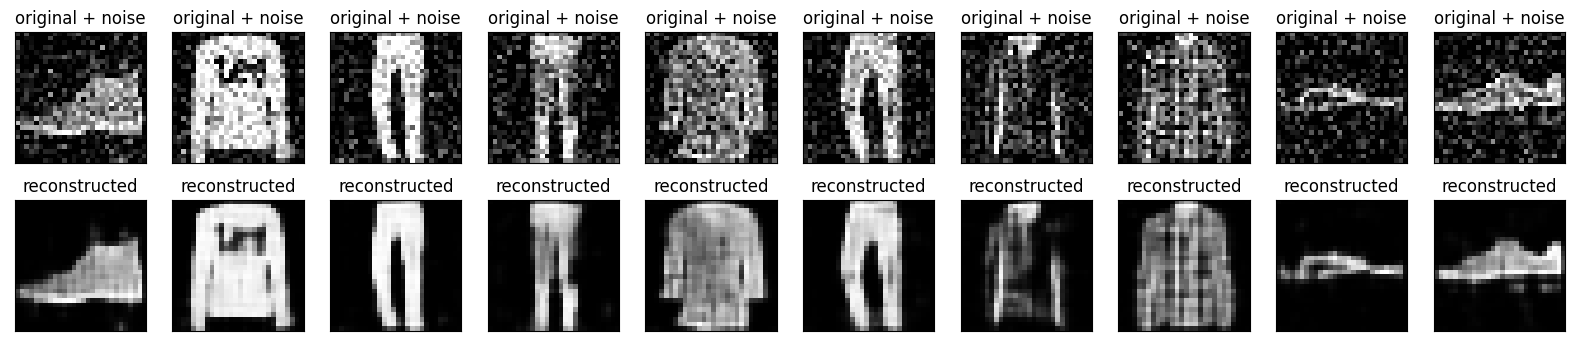

In [19]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Third example: Anomaly detection

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [20]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [21]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [22]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [23]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG. 

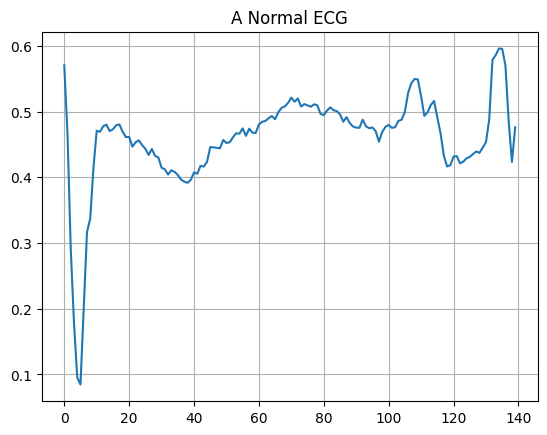

In [24]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

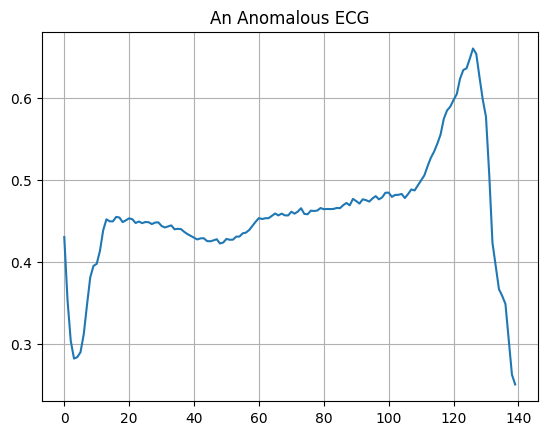

In [25]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [26]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [27]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [28]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20


1/5 [=====>........................] - ETA: 7s - loss: 0.0587

5/5 [==============================] - 2s 40ms/step - loss: 0.0580 - val_loss: 0.0536


Epoch 2/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0572

5/5 [==============================] - 0s 10ms/step - loss: 0.0565 - val_loss: 0.0524


Epoch 3/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0550

5/5 [==============================] - 0s 10ms/step - loss: 0.0541 - val_loss: 0.0510


Epoch 4/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0517

5/5 [==============================] - 0s 10ms/step - loss: 0.0507 - val_loss: 0.0488


Epoch 5/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0483

5/5 [==============================] - 0s 10ms/step - loss: 0.0467 - val_loss: 0.0465


Epoch 6/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0438

5/5 [==============================] - 0s 10ms/step - loss: 0.0423 - val_loss: 0.0444


Epoch 7/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0397

5/5 [==============================] - 0s 10ms/step - loss: 0.0383 - val_loss: 0.0424


Epoch 8/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0357

5/5 [==============================] - 0s 10ms/step - loss: 0.0349 - val_loss: 0.0411


Epoch 9/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0328

5/5 [==============================] - 0s 10ms/step - loss: 0.0321 - val_loss: 0.0399


Epoch 10/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0307

5/5 [==============================] - 0s 10ms/step - loss: 0.0299 - val_loss: 0.0389


Epoch 11/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0286

5/5 [==============================] - 0s 10ms/step - loss: 0.0281 - val_loss: 0.0378


Epoch 12/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0276

5/5 [==============================] - 0s 10ms/step - loss: 0.0267 - val_loss: 0.0374


Epoch 13/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0264

5/5 [==============================] - 0s 10ms/step - loss: 0.0256 - val_loss: 0.0366


Epoch 14/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0248

5/5 [==============================] - 0s 10ms/step - loss: 0.0248 - val_loss: 0.0362


Epoch 15/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0250

5/5 [==============================] - 0s 10ms/step - loss: 0.0243 - val_loss: 0.0358


Epoch 16/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0234

5/5 [==============================] - 0s 10ms/step - loss: 0.0237 - val_loss: 0.0352


Epoch 17/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0237

5/5 [==============================] - 0s 10ms/step - loss: 0.0233 - val_loss: 0.0351


Epoch 18/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0235

5/5 [==============================] - 0s 10ms/step - loss: 0.0228 - val_loss: 0.0348


Epoch 19/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0219

5/5 [==============================] - 0s 10ms/step - loss: 0.0224 - val_loss: 0.0344


Epoch 20/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0230

5/5 [==============================] - 0s 10ms/step - loss: 0.0220 - val_loss: 0.0344


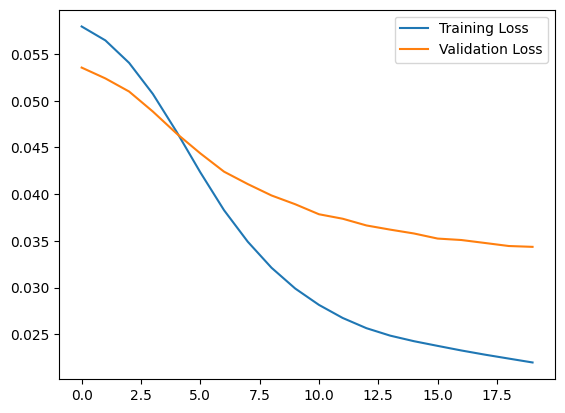

In [29]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

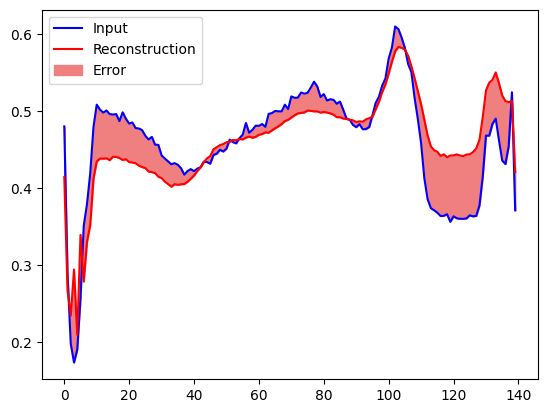

In [30]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

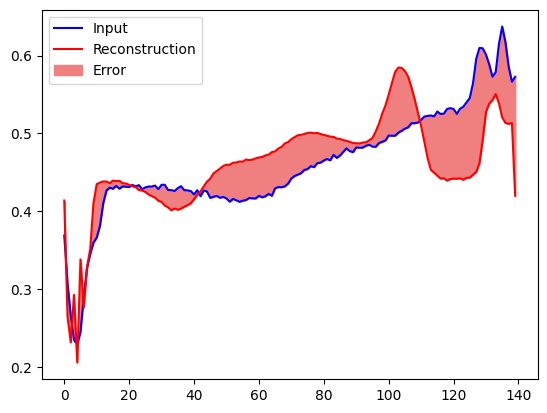

In [31]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

 1/74 [..............................] - ETA: 6s

42/74 [================>.............] - ETA: 0s

74/74 [==============================] - 0s 1ms/step


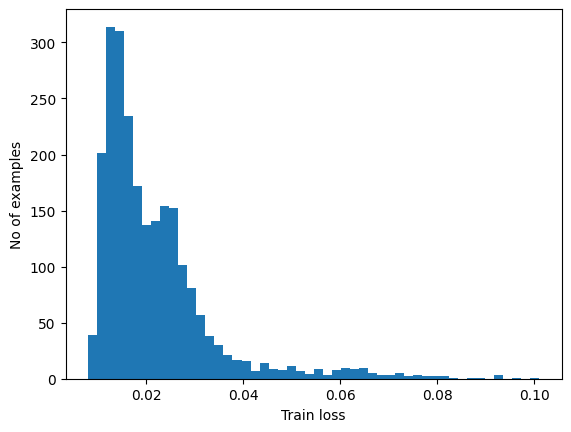

In [32]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [33]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.033845596


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial. 

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier. 

 1/14 [=>............................] - ETA: 0s

14/14 [==============================] - 0s 1ms/step


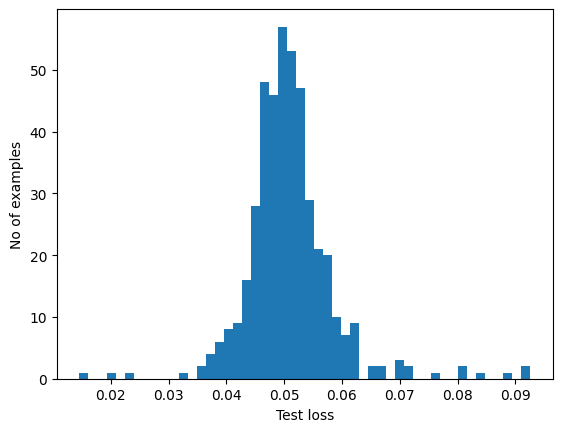

In [34]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [35]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [36]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.943
Precision = 0.9921722113502935
Recall = 0.9053571428571429


## Next steps

To learn more about anomaly detection with autoencoders, check out this excellent [interactive example](https://anomagram.fastforwardlabs.com/#/) built with TensorFlow.js by Victor Dibia. For a real-world use case, you can learn how [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) using TensorFlow. To learn more about the basics, consider reading this [blog post](https://blog.keras.io/building-autoencoders-in-keras.html) by François Chollet. For more details, check out chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.
